# **JPM MLCOE TSRL 2026 Q1**
---
**Heartie CHEN**

## 0. Global Configurations
---

In [1]:
# Core dependencies for data ingestion, modeling, and evaluation.
from pathlib import Path
import json
import re
import random
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from typing import Tuple


pd.set_option('display.float_format', lambda v: f"{v:,.2f}")


print('yfinance:', yf.__version__)
print('pandas:', pd.__version__)
print('tensorflow:', tf.__version__)

yfinance: 1.1.0
pandas: 3.0.0
tensorflow: 2.20.0


In [2]:
# Fix RNG seeds for reproducibility across runs.
CONFIG_DIR = Path('..').resolve() / 'config'
with open(CONFIG_DIR / 'model_config.json', 'r', encoding = 'utf-8-sig') as f:
    MODEL_CONFIG = json.load(f)

SEED = int(MODEL_CONFIG['seed'])
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Configure cache location and statement frequency.
DATA_DIR = Path('..').resolve() / MODEL_CONFIG['data_dir']
DATA_DIR.mkdir(parents = True, exist_ok = True)
TARGET_FREQ = MODEL_CONFIG['target_freq']

## 1. Data Pipeline
---

### 1.1 Column Aliases and Identity Checks

In [4]:
# Provider column aliases to canonical balance sheet names.
BS_ALIASES = MODEL_CONFIG['bs_aliases']


def canonicalize_bs(df: pd.DataFrame) -> pd.DataFrame:
    """Return a balance sheet with canonical column names."""

    rename_map = {}

    for canon, candidates in BS_ALIASES.items():
        for c in candidates:

            if c in df.columns:
                rename_map[c] = canon
                
                break


    return df.rename(columns = rename_map)


def identity_residual(df: pd.DataFrame) -> pd.Series:
    """Compute balance sheet identity residuals."""

    if "Total Liabilities" not in df.columns or "Total Equity" not in df.columns:
        df = canonicalize_bs(df)
    
    required = ["Total Assets", "Total Liabilities", "Total Equity"]
    missing = [c for c in required if c not in df]

    if missing:

        raise KeyError(f"Missing columns: {missing}")


    return df["Total Assets"] - (df["Total Liabilities"] + df["Total Equity"])


def summarize_identity(resid: pd.Series) -> pd.Series:
    """Summarize residual statistics."""

    return pd.Series({

        "mean": resid.mean(),
        "std": resid.std(),
        "max_abs": resid.abs().max(),
    })

### 1.2 Load Data with Caching


In [5]:
# Ticker normalization and cached statement loading utilities.
SPECIAL_TICKERS = MODEL_CONFIG['special_tickers']
FISCAL_YEAR_END_MONTHS_RAW = MODEL_CONFIG.get('fiscal_year_end_months', {})


def normalize_ticker(raw: str) -> str:
    """Normalize tickers and apply project-specific mappings."""

    value = raw.strip()
    upper = value.upper()

    if upper in SPECIAL_TICKERS:

        return SPECIAL_TICKERS[upper]

    if re.fullmatch(r"\d+", value):

        return value.zfill(4) + ".HK"


    return upper


FISCAL_YEAR_END_MONTHS = {
    normalize_ticker(k): int(v) for k, v in FISCAL_YEAR_END_MONTHS_RAW.items()
}


def slugify(ticker: str) -> str:
    """Create a filesystem-friendly slug for a ticker."""

    return re.sub(r"[^a-z0-9]+", "_", ticker.lower()).strip("_")


def _fetch_statements(tkr, freq: str):
    """Fetch statements from Yahoo Finance for a ticker."""

    bs = tkr.get_balance_sheet(freq = freq)
    is_df = tkr.get_financials(freq = freq)

    if bs is None or is_df is None:

        return pd.DataFrame(), pd.DataFrame()

    bs = bs.T.sort_index()
    is_df = is_df.T.sort_index()


    return bs, is_df


def _load_cached(path: Path) -> pd.DataFrame:
    """Load a cached statement CSV if available."""

    return pd.read_csv(path, index_col = 0, parse_dates = True)


def load_statements(ticker: str, freq: str = TARGET_FREQ):
    """Load or fetch statements for a ticker and frequency."""

    ticker = normalize_ticker(ticker)
    slug = slugify(ticker)
    freq = freq.lower()

    data_dir = DATA_DIR / freq
    data_dir.mkdir(parents = True, exist_ok = True)

    bs_path = data_dir / f"{slug}_balance_sheet_{freq}.csv"
    is_path = data_dir / f"{slug}_income_statement_{freq}.csv"

    # Prefer cached CSVs to reduce API calls.

    if bs_path.exists() and is_path.exists():
        bs = _load_cached(bs_path)
        is_df = _load_cached(is_path)

    else:
        tkr = yf.Ticker(ticker)
        bs, is_df = _fetch_statements(tkr, freq)

        if not bs.empty and not is_df.empty:
            bs.to_csv(bs_path)
            is_df.to_csv(is_path)

    if bs.empty or is_df.empty:

        raise RuntimeError(f"Failed to fetch statements for {ticker} ({freq})")

    bs = canonicalize_bs(bs)


    return bs, is_df, freq


TICKERS = MODEL_CONFIG['tickers']
PRIMARY_TICKER = MODEL_CONFIG.get('primary_ticker', TICKERS[0])
bs, is_df, stmt_freq = load_statements(PRIMARY_TICKER, freq = TARGET_FREQ)


print("Loaded tickers:", [normalize_ticker(t) for t in TICKERS])
print("Statement frequency:", stmt_freq)
print("Balance sheet shape:", bs.shape)
print("Income statement shape:", is_df.shape)
print("Identity residual stats:", summarize_identity(identity_residual(bs)))


bs.head()

Loaded tickers: ['AAPL', 'GOOG', '0700.HK', '1810.HK', 'IBM', 'TSLA', '9633.HK', '9987.HK', '9988.HK', 'IBKR', 'KO', 'MCD', 'EL', 'BRK-B', 'NESN.SW']
Statement frequency: yearly
Balance sheet shape: (5, 69)
Income statement shape: (5, 39)
Identity residual stats: mean      0.00
std       0.00
max_abs   0.00
dtype: float64


,TreasurySharesNumber,OrdinarySharesNumber,ShareIssued,NetDebt,TotalDebt,TangibleBookValue,InvestedCapital,WorkingCapital,NetTangibleAssets,CapitalLeaseObligations,...,OtherCurrentAssets,Inventory,Receivables,OtherReceivables,Accounts Receivable,CashCashEquivalentsAndShortTermInvestments,OtherShortTermInvestments,CashAndCashEquivalents,CashEquivalents,CashFinancial
2021-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"11,803,000,000.00",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-30,NaN,"15,943,425,000.00","15,943,425,000.00","96,423,000,000.00","132,480,000,000.00","50,672,000,000.00","170,741,000,000.00","-18,577,000,000.00","50,672,000,000.00","12,411,000,000.00",...,"21,223,000,000.00","4,946,000,000.00","60,932,000,000.00","32,748,000,000.00","28,184,000,000.00","48,304,000,000.00","24,658,000,000.00","23,646,000,000.00","5,100,000,000.00","18,546,000,000.00"
2023-09-30,0.00,"15,550,061,000.00","15,550,061,000.00","81,123,000,000.00","111,088,000,000.00","62,146,000,000.00","173,234,000,000.00","-1,742,000,000.00","62,146,000,000.00","12,842,000,000.00",...,"14,695,000,000.00","6,331,000,000.00","60,985,000,000.00","31,477,000,000.00","29,508,000,000.00","61,555,000,000.00","31,590,000,000.00","29,965,000,000.00","1,606,000,000.00","28,359,000,000.00"
2024-09-30,NaN,"15,116,786,000.00","15,116,786,000.00","76,686,000,000.00","106,629,000,000.00","56,950,000,000.00","163,579,000,000.00","-23,405,000,000.00","56,950,000,000.00",NaN,...,"14,287,000,000.00","7,286,000,000.00","66,243,000,000.00","32,833,000,000.00","33,410,000,000.00","65,171,000,000.00","35,228,000,000.00","29,943,000,000.00","2,744,000,000.00","27,199,000,000.00"
2025-09-30,NaN,"14,773,260,000.00","14,773,260,000.00","62,723,000,000.00","98,657,000,000.00","73,733,000,000.00","172,390,000,000.00","-17,674,000,000.00","73,733,000,000.00",NaN,...,"14,585,000,000.00","5,718,000,000.00","72,957,000,000.00","33,180,000,000.00","39,777,000,000.00","54,697,000,000.00","18,763,000,000.00","35,934,000,000.00","7,667,000,000.00","28,267,000,000.00"


## 2. Features & Dataset
---

### 2.1 Feature Engineering

#### 2.1.1 Derived Drivers (DSO/DPO/DIH, Margins, Growth, Logs)

In [6]:
# Feature engineering for working-capital efficiency and margins.
def _pick(df: pd.DataFrame, options):
    """Pick the first available series from the provided options."""

    for c in options:

        if c in df.columns:

            return df[c]

    raise KeyError(f'Missing columns: {options}')


def _as_series(values, index) -> pd.Series:
    """Return values as a Series aligned to the provided index."""

    if isinstance(values, pd.Series):

        return values.reindex(index)

    return pd.Series(values, index = index)


def fiscal_month_from_stmt(stmt_month: pd.Series, fy_end_month) -> pd.Series:
    """Map statement month to fiscal month number (1-12)."""

    if fy_end_month is None:

        return stmt_month.astype(float)

    fy_end_series = _as_series(fy_end_month, stmt_month.index)
    fy_end_series = fy_end_series.fillna(stmt_month)
    fy_start = (fy_end_series % 12) + 1
    fiscal_month = ((stmt_month - fy_start) % 12) + 1

    return fiscal_month.astype(float)


def fiscal_quarter_from_stmt(stmt_month: pd.Series, fy_end_month) -> pd.Series:
    """Map statement month to fiscal quarter number (1-4)."""

    if fy_end_month is None:

        return ((stmt_month - 1) // 3) + 1

    fy_end_series = _as_series(fy_end_month, stmt_month.index)
    fy_end_series = fy_end_series.fillna(stmt_month)
    offset = (stmt_month - fy_end_series) % 12
    fiscal_quarter = ((offset // 3 + 3) % 4) + 1

    return fiscal_quarter.astype(int)


def compute_features(
    bs: pd.DataFrame,
    is_df: pd.DataFrame,
    ticker: str | None = None,
    days: float = 365.0,
    growth_periods: int = 1
) -> pd.DataFrame:
    """Compute financial ratios and growth features."""

    rev = _pick(is_df, ['Total Revenue', 'Operating Revenue', 'TotalRevenue', 'OperatingRevenue', 'Revenues'])
    cogs = _pick(is_df, ['Cost Of Revenue', 'Cost of Revenue', 'CostOfRevenue', 'ReconciledCostOfRevenue'])
    op_inc = _pick(is_df, ['Operating Income', 'OperatingIncome'])
    net_inc = _pick(is_df, ['Net Income', 'NetIncome', 'NetIncomeFromContinuingOperationNetMinorityInterest'])
    ar = _pick(bs, ['Accounts Receivable', 'AccountsReceivable'])
    ap = _pick(bs, ['Accounts Payable', 'AccountsPayable'])
    inv = _pick(bs, ['Inventory', 'Inventories'])

    feats = pd.DataFrame(index = bs.index)

    sales_per_day = rev / days
    cogs_per_day = cogs / days

    feats['dso'] = ar / sales_per_day
    feats['dpo'] = ap / cogs_per_day
    feats['dih'] = inv / cogs_per_day
    feats['gross_margin'] = (rev - cogs) / rev
    feats['op_margin'] = op_inc / rev
    feats['net_margin'] = net_inc / rev
    feats['rev_yoy'] = rev.pct_change(periods = growth_periods)
    feats['cogs_yoy'] = cogs.pct_change(periods = growth_periods)
    feats['netinc_yoy'] = net_inc.pct_change(periods = growth_periods)
    feats['log_rev'] = np.log1p(rev)
    feats['log_assets'] = np.log1p(_pick(bs, ['Total Assets', 'TotalAssets']))

    # Fiscal seasonality aligned to fiscal year end month when configured.
    stmt_month = pd.Series(pd.to_datetime(bs.index).month, index = bs.index)
    fy_end_month = FISCAL_YEAR_END_MONTHS.get(ticker) if ticker else None
    fiscal_month = fiscal_month_from_stmt(stmt_month, fy_end_month)
    feats['fiscal_month_sin'] = np.sin(2 * np.pi * fiscal_month / 12.0)
    feats['fiscal_month_cos'] = np.cos(2 * np.pi * fiscal_month / 12.0)
    fiscal_quarter = fiscal_quarter_from_stmt(stmt_month, fy_end_month)

    for q in range(1, 5):
        feats[f'fiscal_q{q}'] = (fiscal_quarter == q).astype(float)
    
    feats = feats.replace([np.inf, -np.inf], np.nan)
    feats = feats.sort_index().ffill().bfill()


    return feats


period_days = 365.0 if TARGET_FREQ == 'yearly' else 90.0
growth_periods = 1 if TARGET_FREQ == 'yearly' else 4

primary_ticker = normalize_ticker(PRIMARY_TICKER)
features = compute_features(
    bs,
    is_df,
    ticker = primary_ticker,
    days = period_days,
    growth_periods = growth_periods
)
features.tail()

,dso,dpo,dih,gross_margin,op_margin,net_margin,rev_yoy,cogs_yoy,netinc_yoy,log_rev,log_assets,fiscal_month_sin,fiscal_month_cos,fiscal_q1,fiscal_q2,fiscal_q3,fiscal_q4
2021-09-30,26.09,104.69,8.08,0.43,0.30,0.25,-0.03,-0.04,-0.03,26.70,26.59,-0.00,1.00,0.00,0.00,0.00,1.00
2022-09-30,26.09,104.69,8.08,0.43,0.30,0.25,-0.03,-0.04,-0.03,26.70,26.59,-0.00,1.00,0.00,0.00,0.00,1.00
2023-09-30,28.10,106.72,10.79,0.44,0.30,0.25,-0.03,-0.04,-0.03,26.67,26.59,-0.00,1.00,0.00,0.00,0.00,1.00
2024-09-30,31.19,119.66,12.64,0.46,0.32,0.24,0.02,-0.02,-0.03,26.69,26.62,-0.00,1.00,0.00,0.00,0.00,1.00
2025-09-30,34.89,115.40,9.45,0.47,0.32,0.27,0.06,0.05,0.19,26.75,26.61,-0.00,1.00,0.00,0.00,0.00,1.00


### 2.2 Dataset Assembly

In [7]:
# Assemble aligned dataset across tickers with required columns.
TARGET_BS = MODEL_CONFIG['target_bs']
TARGET_LE = MODEL_CONFIG['target_le']
NET_INCOME_COL = MODEL_CONFIG['net_income_col']
STATE_COLS = MODEL_CONFIG['state_cols']


def _has_any(df: pd.DataFrame, options: list[str]) -> bool:
    """Return True if any candidate column exists."""

    return any(c in df.columns for c in options)


def missing_required_columns(bs: pd.DataFrame, is_df: pd.DataFrame) -> list[str]:
    """Return missing required columns for BS and IS."""

    missing = []

    if not _has_any(bs, ['Total Assets', 'TotalAssets']):
        missing.append('Total Assets')
    
    if not _has_any(bs, ['Total Liabilities', 'Total Liabilities', 'TotalLiabilities', 'Total Liabilities Net Minority Interest', 'TotalLiabilitiesNetMinorityInterest']):
        missing.append('Total Liabilities')
    
    if not _has_any(bs, ['Total Equity', 'Stockholders Equity', 'StockholdersEquity', 'Total Equity Gross Minority Interest', 'TotalEquityGrossMinorityInterest']):
        missing.append('Total Equity')
    
    if not _has_any(bs, ['Accounts Receivable', 'AccountsReceivable']):
        missing.append('Accounts Receivable')
    
    if not _has_any(bs, ['Accounts Payable', 'AccountsPayable']):
        missing.append('Accounts Payable')
    
    if not _has_any(bs, ['Inventory', 'Inventories']):
        missing.append('Inventory')
    
    if not _has_any(bs, ['Net PPE', 'NetPPE']):
        missing.append('Net PPE')
    
    if not _has_any(bs, ['Retained Earnings', 'RetainedEarnings']):
        missing.append('Retained Earnings')

    if not _has_any(is_df, ['Total Revenue', 'Operating Revenue', 'TotalRevenue', 'OperatingRevenue', 'Revenues']):
        missing.append('Total Revenue')
   
    if not _has_any(is_df, ['Cost Of Revenue', 'Cost of Revenue', 'CostOfRevenue', 'ReconciledCostOfRevenue']):
        missing.append('Cost Of Revenue')
    
    if not _has_any(is_df, ['Operating Income', 'OperatingIncome']):
        missing.append('Operating Income')
    
    if not _has_any(is_df, ['Net Income', 'NetIncome', 'NetIncomeFromContinuingOperationNetMinorityInterest']):
        missing.append('Net Income')


    return missing


def build_aligned_for_ticker(ticker: str) -> pd.DataFrame:
    """Build an aligned dataset for one ticker."""

    bs, is_df, freq = load_statements(ticker, freq = TARGET_FREQ)
    missing = missing_required_columns(bs, is_df)
    
    if missing:

        print(f"{ticker}: skip, missing {missing}")

        return pd.DataFrame()

    period_days = 365.0 if freq == 'yearly' else 90.0
    growth_periods = 1 if freq == 'yearly' else 4

    features = compute_features(bs, is_df, ticker = ticker, days = period_days, growth_periods = growth_periods)
    
    # Use lagged features (t-1) to predict current targets (t).
    features = features.shift(1)
    targets = bs[TARGET_BS].copy()
    net_income = _pick(is_df, ['Net Income', 'NetIncome', 'NetIncomeFromContinuingOperationNetMinorityInterest']).rename(NET_INCOME_COL)
    net_income = net_income.reindex(targets.index)

    # Align features, targets, and net income on shared dates.
    dataset = features.join(targets, how = 'inner').join(net_income, how = 'inner')
    dataset = dataset.dropna()

    rev_series = _pick(is_df, ['Total Revenue', 'Operating Revenue', 'TotalRevenue', 'OperatingRevenue', 'Revenues'])
    
    # Shift state variables to create t-1 inputs.
    prev_state_df = bs.reindex(columns = STATE_COLS).shift(1)
    prev_state_df.columns = [f'prev_{c}' for c in STATE_COLS]
    prev_state_df['prev_Total Revenue'] = rev_series.reindex(targets.index).shift(1)

    # Combine current data with lagged state for modeling.
    aligned = dataset.join(prev_state_df, how = 'inner').dropna()
    aligned['ticker'] = ticker
    aligned['stmt_freq'] = freq


    return aligned


# Aggregate aligned datasets across tickers.
aligned_list = []

for ticker in [normalize_ticker(t) for t in TICKERS]:

    try:
        aligned_t = build_aligned_for_ticker(ticker)

        if aligned_t.empty:

            print(f"{ticker}: empty after alignment")

        else:

            print(f"{ticker}: aligned rows = {aligned_t.shape[0]}")
            aligned_list.append(aligned_t)

    except Exception as exc:

        print(f"{ticker}: failed ({exc})")

if not aligned_list:

    raise RuntimeError('No aligned data available')

aligned = pd.concat(aligned_list, axis = 0).sort_index()
prev_cols = [f'prev_{c}' for c in STATE_COLS] + ['prev_Total Revenue']
drop_cols = TARGET_BS + [NET_INCOME_COL] + prev_cols + ['ticker', 'stmt_freq']
FEATURE_COLS = [c for c in aligned.columns if c not in drop_cols]


print('Dataset shape:', aligned.shape)
print('Feature cols:', len(FEATURE_COLS), 'Target cols:', len(TARGET_LE) + 1)
print('Tickers:', aligned['ticker'].nunique())

AAPL: aligned rows = 3
GOOG: aligned rows = 2
0700.HK: aligned rows = 3
1810.HK: aligned rows = 3
IBM: aligned rows = 3
TSLA: aligned rows = 3
9633.HK: skip, missing ['Retained Earnings']
9633.HK: empty after alignment
9987.HK: aligned rows = 3
9988.HK: aligned rows = 2
IBKR: skip, missing ['Inventory', 'Net PPE']
IBKR: empty after alignment
KO: aligned rows = 3
MCD: aligned rows = 3
EL: aligned rows = 3
BRK-B: skip, missing ['Accounts Payable', 'Inventory', 'Cost Of Revenue', 'Operating Income']
BRK-B: empty after alignment
NESN.SW: aligned rows = 3
Dataset shape: (34, 31)
Feature cols: 17 Target cols: 3
Tickers: 12


### 2.3 Prev-state Matrix for Algebraic Layer

In [8]:
# Build model-ready arrays for features, targets, and state inputs.
X_feat = aligned[FEATURE_COLS].values.astype('float32')
Y_bs = aligned[TARGET_LE].values.astype('float32')
Y_earn = aligned[[NET_INCOME_COL]].values.astype('float32')
X_prev = aligned[prev_cols].values.astype('float32')


print('Aligned shapes:', X_feat.shape, X_prev.shape, Y_bs.shape, Y_earn.shape)

Aligned shapes: (34, 17) (34, 8) (34, 2) (34, 1)


### 2.4 Scaling (z-score) for Stability

In [9]:
# Standardize inputs and targets for stable optimization.
feat_scaler = StandardScaler()
bs_scaler = StandardScaler()
earn_scaler = StandardScaler()
prev_scaler = StandardScaler()

X_feat_scaled = feat_scaler.fit_transform(X_feat)
Y_bs_scaled = bs_scaler.fit_transform(Y_bs)
Y_earn_scaled = earn_scaler.fit_transform(Y_earn)
X_prev_scaled = prev_scaler.fit_transform(X_prev)

### 2.5 Train/Val Split on Scaled Data

In [10]:
# Time-ordered split to reduce look-ahead leakage (per-ticker fixed windows).
min_oos = 2
min_val = 1

n = X_feat_scaled.shape[0]
train_mask = np.zeros(n, dtype = bool)
val_mask = np.zeros(n, dtype = bool)
test_mask = np.zeros(n, dtype = bool)

for ticker in aligned['ticker'].unique():

    pos = np.where(aligned['ticker'].values == ticker)[0]
    pos = pos[np.argsort(aligned.index.values[pos])]

    if len(pos) <= (min_val + 1):
        train_mask[pos] = True

        continue

    oos_size = min(min_oos, max(1, len(pos) - min_val - 1))
    test_start = len(pos) - oos_size
    val_start = max(test_start - min_val, 0)

    train_mask[pos[:val_start]] = True
    val_mask[pos[val_start:test_start]] = True
    test_mask[pos[test_start:]] = True

X_train_feat = X_feat_scaled[train_mask]
Y_train_bs = Y_bs_scaled[train_mask]
Y_train_earn = Y_earn_scaled[train_mask]
X_train_prev = X_prev_scaled[train_mask]

X_val_feat = X_feat_scaled[val_mask]
Y_val_bs = Y_bs_scaled[val_mask]
Y_val_earn = Y_earn_scaled[val_mask]
X_val_prev = X_prev_scaled[val_mask]

X_test_feat = X_feat_scaled[test_mask]
Y_test_bs = Y_bs_scaled[test_mask]
Y_test_earn = Y_earn_scaled[test_mask]
X_test_prev = X_prev_scaled[test_mask]

test_index = aligned.index[test_mask]

print('Scaled train:', X_train_feat.shape, Y_train_bs.shape, Y_train_earn.shape)
print('Scaled val:', X_val_feat.shape, Y_val_bs.shape, Y_val_earn.shape)
print('Scaled test:', X_test_feat.shape, Y_test_bs.shape, Y_test_earn.shape)


Scaled train: (14, 17) (14, 2) (14, 1)
Scaled val: (10, 17) (10, 2) (10, 1)
Scaled test: (10, 17) (10, 2) (10, 1)


## 3. TensorFlow
---
*Pareja/Pelaez Constrained*

### 3.1 TF Model with Algebraic Generator + Earnings Head

In [11]:
class AlgebraicBS(keras.layers.Layer):
    """Layer that enforces algebraic balance sheet constraints."""

    def __init__(self):
        """Initialize sublayers for balance sheet generation."""
        
        super().__init__()
        
        self.hidden = keras.layers.Dense(64, activation = 'relu')
        self.rev_head = keras.layers.Dense(1, activation = 'relu')
        self.cogs_head = keras.layers.Dense(1, activation = 'relu')
        self.drivers = keras.layers.Dense(5)
        self.margin_head = keras.layers.Dense(1)
        self.payout_head = keras.layers.Dense(1)
        self.earn_params = keras.layers.Dense(2, name = 'net_income_params')


    def call(self, inputs: Tuple[tf.Tensor, tf.Tensor]):
        """Compute constrained balance sheet and earnings outputs."""

        if not isinstance(inputs, (tuple, list)):

            raise TypeError("inputs must be (features, prev_state)")

        features, prev_state = inputs
        ar_prev, ap_prev, inv_prev, ppe_prev, liab_prev, equity_prev, re_prev, rev_prev = tf.split(prev_state, num_or_size_splits = 8, axis = -1)
        hidden = self.hidden(features)
        rev_predicate = self.rev_head(hidden)
        cogs_predicate = self.cogs_head(hidden)
        drivers_raw = self.drivers(hidden)

        dso = tf.nn.softplus(drivers_raw[:, 0:1])
        dpo = tf.nn.softplus(drivers_raw[:, 1:2])
        dih = tf.nn.softplus(drivers_raw[:, 2:3])
        dep_rate = tf.nn.sigmoid(drivers_raw[:, 3:4]) * 0.2
        capex_rate = tf.nn.sigmoid(drivers_raw[:, 4:5]) * 0.2
        net_margin = tf.tanh(self.margin_head(hidden)) * 0.5
        div_payout = tf.nn.sigmoid(self.payout_head(hidden))

        sales_per_day = rev_predicate / 365.0
        cogs_per_day = cogs_predicate / 365.0

        ar_next = dso * sales_per_day
        ap_next = dpo * cogs_per_day
        inv_next = dih * cogs_per_day
        dep = dep_rate * ppe_prev
        capex = capex_rate * rev_predicate
        ppe_next = ppe_prev + capex - dep
        net_income = net_margin * rev_predicate
        # TFP: output loc/scale parameters for earnings distribution.
        earn_params = self.earn_params(hidden)
        earn_predicate = earn_params
        div = div_payout * net_income
        re_next = re_prev + net_income - div

        other_equity = tf.nn.relu(equity_prev - re_prev)

        equity_next = re_next + other_equity

        other_liab_prev = tf.nn.relu(liab_prev - ap_prev)
        growth = tf.where(rev_prev > 0, rev_predicate / rev_prev - 1.0, tf.zeros_like(rev_predicate))

        other_liab_next = other_liab_prev * (1.0 + growth)
        liab_next = ap_next + other_liab_next
        assets_wo_cash = ar_next + inv_next + ppe_next
        cash_next = equity_next + liab_next - assets_wo_cash
        assets_next = liab_next + equity_next
        # Output liabilities and equity; assets are derived as L + E downstream.
        bs_out = tf.concat([liab_next, equity_next], axis = -1)


        return bs_out, earn_predicate


def build_pareja_model(feat_dim: int, state_dim: int = 8):
    """Build a Pareja/Pelaez-constrained model."""

    feat_in = keras.Input(shape = (feat_dim,), name = 'features')
    state_in = keras.Input(shape = (state_dim,), name = 'prev_state')
    bs_out, earn_out = AlgebraicBS()([feat_in, state_in])
    bs_out = keras.layers.Lambda(lambda x: x, name = 'bs_out')(bs_out)
    earn_out = keras.layers.Lambda(lambda x: x, name = 'earn_params')(earn_out)
    
    
    return keras.Model([feat_in, state_in], [bs_out, earn_out], name = 'bs_pareja_style')


pareja_model = build_pareja_model(feat_dim = X_feat_scaled.shape[1], state_dim = X_prev_scaled.shape[1])
pareja_model.summary()

Model: "bs_pareja_style"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prev_state          │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ algebraic_bs        │ [(None, 2),       │      1,867 │ features[0][0],   │
│ (AlgebraicBS)       │ (None, 2)]        │            │ prev_state[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bs_out (Lambda)     │ (None, 2)         │          0 │ algebraic_bs[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ earn_params         │ (None, 2)         │          0 │ algebraic_bs[0][… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,867 (7.29 KB)

 Trainable params: 1,867 (7.29 KB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Tests / Sanity Checks

#### 3.2.1 Unit test

In [12]:
# Fast unit checks on core helpers and feature output.
print('Running Unit test...')

try: 
    idx = pd.to_datetime(['2023-12-31', '2024-12-31'])

    sample_bs = pd.DataFrame(
        {
            'TotalAssets': [100.0, 120.0],
            'TotalLiabilities': [60.0, 70.0],
            'StockholdersEquity': [40.0, 50.0],
            'AccountsReceivable': [10.0, 12.0],
            'AccountsPayable': [8.0, 9.0],
            'Inventory': [5.0, 6.0],
            'NetPPE': [20.0, 22.0],
            'RetainedEarnings': [15.0, 18.0],
        },

        index = idx,
    )

    sample_is = pd.DataFrame(
        {
            'TotalRevenue': [80.0, 90.0],
            'CostOfRevenue': [30.0, 35.0],
            'OperatingIncome': [10.0, 12.0],
            'NetIncome': [8.0, 9.0],
        },

        index = idx,
    )

    canon = canonicalize_bs(sample_bs)

    assert 'Total Assets' in canon.columns, 'canonicalize_bs failed for Total Assets'
    assert 'Total Liabilities' in canon.columns, 'canonicalize_bs failed for Total Liabilities'
    assert 'Total Equity' in canon.columns, 'canonicalize_bs failed for Total Equity'

    resid = identity_residual(canon)
    assert np.allclose(resid.values, 0.0), 'identity_residual should be zero for balanced data'

    missing = missing_required_columns(sample_bs, sample_is)
    assert missing == [], f'missing_required_columns unexpected: {missing}'

    features_test = compute_features(sample_bs, sample_is, days = 365.0, growth_periods = 1)

    expected_cols = {
        'dso', 'dpo', 'dih', 'gross_margin', 'op_margin', 'net_margin',
        'rev_yoy', 'cogs_yoy', 'netinc_yoy', 'log_rev', 'log_assets'
    }

    assert expected_cols.issubset(set(features_test.columns)), 'compute_features missing expected columns'
    assert np.isfinite(features_test.to_numpy()).all(), 'compute_features produced non-finite values'

    print('Unit tests passed.')

except Exception as e:
    print('Unit tests failed:', e)

    raise

Running Unit test...
Unit tests passed.


#### 3.2.2 Integration test

In [13]:
# Minimal end-to-end sanity check of model outputs.
print('Running Integration test...')

try:
    assert aligned.shape[0] > 0, 'aligned dataset is empty'
    assert X_feat.shape[0] == Y_bs.shape[0] == Y_earn.shape[0] == X_prev.shape[0], 'array length mismatch'

    test_batch = min(2, X_train_feat.shape[0])
    assert test_batch > 0, 'empty training batch'

    bs_hat, earn_hat = pareja_model([X_train_feat[:test_batch], X_train_prev[:test_batch]], training = False)
    assert bs_hat.shape[-1] == len(TARGET_LE), 'unexpected BS output width'
    assert earn_hat.shape[-1] == 2, 'unexpected earnings param width'

    print('Integration tests passed.')

except Exception as e:
    print('Integration tests failed:', e)

    raise

Running Integration test...
Integration tests passed.


### 3.2 Train/Evaluate
*MAE on BS + TFP on Earnings*

In [14]:
# Train with MAE on balance sheet and NLL on earnings.
def negloglik(y_true, y_pred):
    """TFP: Normal NLL for earnings using loc/scale parameters."""
    
    loc = y_pred[..., :1]
    scale = tf.nn.softplus(y_pred[..., 1:]) + 1e-3
    dist = tfp.distributions.Normal(loc = loc, scale = scale)
    

    return -dist.log_prob(y_true)


pareja_model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = [keras.losses.MeanAbsoluteError(), negloglik],
    loss_weights = [1.0, 0.3],
)

hist = pareja_model.fit(
    [X_train_feat, X_train_prev], [Y_train_bs, Y_train_earn],
    
    validation_data = (
        [X_val_feat, X_val_prev], [Y_val_bs, Y_val_earn]
    ) if len(X_val_feat) > 0 else None,
    
    epochs = 20,
    batch_size = 2,
    verbose = 0,
)

In [15]:
# Invert scaling for outputs in original units.
bs_predicate_scaled, earn_params_scaled = pareja_model([X_feat_scaled, X_prev_scaled], training = False)
bs_predicate = bs_scaler.inverse_transform(bs_predicate_scaled.numpy())
earn_loc_scaled = earn_params_scaled[:, :1]
earn_scale_scaled = tf.nn.softplus(earn_params_scaled[:, 1:]) + 1e-3
earn_predicate = earn_scaler.inverse_transform(earn_loc_scaled.numpy())
earn_predicate_std = earn_scale_scaled.numpy() * earn_scaler.scale_[0]

In [16]:
# Reconstruct full balance sheet and error metrics.
bs_predicate_df = pd.DataFrame(bs_predicate, columns = TARGET_LE, index = aligned.index)
assets_predicate = bs_predicate_df['Total Liabilities'] + bs_predicate_df['Total Equity']
bs_predicate_full = bs_predicate_df.copy()
bs_predicate_full['Total Assets'] = assets_predicate
bs_predicate_full = bs_predicate_full[TARGET_BS]
resid_predicate = bs_predicate_full['Total Assets'] - (bs_predicate_full['Total Liabilities'] + bs_predicate_full['Total Equity'])

pred_full = bs_predicate_full.copy()
pred_full['ticker'] = aligned['ticker'].values
pred_full['stmt_freq'] = aligned['stmt_freq'].values
pred_full['pred_net_income'] = earn_predicate.flatten()
pred_full['pred_net_income_std'] = earn_predicate_std.flatten()
pred_full['pred_resid'] = pred_full['Total Assets'] - (pred_full['Total Liabilities'] + pred_full['Total Equity'])

actual_bs = aligned[TARGET_BS].copy()
actual_bs.columns = [f'actual_{c}' for c in actual_bs.columns]
pred_full = pd.concat([pred_full, actual_bs], axis = 1)
pred_full['actual_net_income'] = aligned[NET_INCOME_COL].values

pred_full['err_assets'] = pred_full['Total Assets'] - pred_full['actual_Total Assets']
pred_full['err_liab'] = pred_full['Total Liabilities'] - pred_full['actual_Total Liabilities']
pred_full['err_equity'] = pred_full['Total Equity'] - pred_full['actual_Total Equity']
pred_full['err_net_income'] = pred_full['pred_net_income'] - pred_full['actual_net_income']
pred_full['abs_err_assets'] = pred_full['err_assets'].abs()
pred_full['abs_err_liab'] = pred_full['err_liab'].abs()
pred_full['abs_err_equity'] = pred_full['err_equity'].abs()
pred_full['abs_err_net_income'] = pred_full['err_net_income'].abs()

# Aggregate per-ticker diagnostics for reporting.
summary = pred_full.groupby('ticker').agg(
    samples = ('pred_net_income', 'size'),
    mean_pred_assets = ('Total Assets', 'mean'),
    mean_pred_liab = ('Total Liabilities', 'mean'),
    mean_pred_equity = ('Total Equity', 'mean'),
    mean_pred_net_income = ('pred_net_income', 'mean'),
    mean_pred_net_income_std = ('pred_net_income_std', 'mean'),
    mean_actual_assets = ('actual_Total Assets', 'mean'),
    mean_actual_liab = ('actual_Total Liabilities', 'mean'),
    mean_actual_equity = ('actual_Total Equity', 'mean'),
    mean_actual_net_income = ('actual_net_income', 'mean'),
    mae_assets = ('abs_err_assets', 'mean'),
    mae_liab = ('abs_err_liab', 'mean'),
    mae_equity = ('abs_err_equity', 'mean'),
    mae_net_income = ('abs_err_net_income', 'mean'),
)

def format_df_for_view(df: pd.DataFrame, decimals: int = 2) -> pd.DataFrame:
    """Create a display-only view with formatted numerics."""

    view = df.copy()
    num_cols = view.select_dtypes(include = [np.number]).columns
    fmt = f"{{:,.{decimals}f}}"
    view[num_cols] = view[num_cols].map(lambda v: "" if pd.isna(v) else fmt.format(v))


    return view


pred_full = pred_full.reset_index().rename(columns = {'index': 'stmt_date'})
pred_full['stmt_year'] = pred_full['stmt_date'].dt.year
stmt_month = pred_full['stmt_date'].dt.month
fy_end_month = pred_full['ticker'].map(FISCAL_YEAR_END_MONTHS)
fiscal_quarter = fiscal_quarter_from_stmt(stmt_month, fy_end_month)

for q in range(1, 5):
    pred_full[f'fiscal_q{q}'] = (fiscal_quarter == q).astype(int)

pred_full_view = pred_full.set_index(['ticker', 'fiscal_q1', 'fiscal_q2', 'fiscal_q3', 'fiscal_q4'])
pred_full_view = format_df_for_view(pred_full_view)
summary_view = format_df_for_view(summary)

earn_head_str = np.array2string(
    earn_predicate.flatten(),
    formatter = {"float_kind": lambda v: f"{v:,.2f}"}
)

## 4. Results
---

### 4.1 Final Train Losses

In [17]:
loss_rows = [
    {'metric': k, 'value': v[-1]}
    for k, v in hist.history.items()

    if 'loss' in k
]
loss_df = pd.DataFrame(loss_rows).sort_values('metric').reset_index(drop = True)


loss_df

,metric,value
0,bs_out_loss,0.51
1,earn_params_loss,0.13
2,loss,0.55
3,val_bs_out_loss,0.43
4,val_earn_params_loss,-0.04
5,val_loss,0.41


### 4.2 Earnings NLL

NLL curve (train): 
 [1.7229501008987427, 1.4167975187301636, 1.2630186080932617, 1.1580814123153687, 1.0769691467285156, 1.0091651678085327, 0.947149395942688, 0.8873762488365173, 0.827397346496582, 0.7660479545593262, 0.70352703332901, 0.6372533440589905, 0.5682477355003357, 0.49617114663124084, 0.4315604567527771, 0.4480157792568207, 0.38994190096855164, 0.2747800648212433, 0.2649672031402588, 0.13260963559150696] 


NLL curve (val): 
 [1.0995841026306152, 1.0270864963531494, 0.9731532335281372, 0.9248254895210266, 0.8764165639877319, 0.8243690729141235, 0.7686991691589355, 0.7104929685592651, 0.649600088596344, 0.5854341387748718, 0.5196582674980164, 0.45145535469055176, 0.38353222608566284, 0.3028275966644287, 0.2801898419857025, 0.17913590371608734, 0.11327912658452988, 0.08408907055854797, 0.041460681706666946, -0.03821660205721855] 



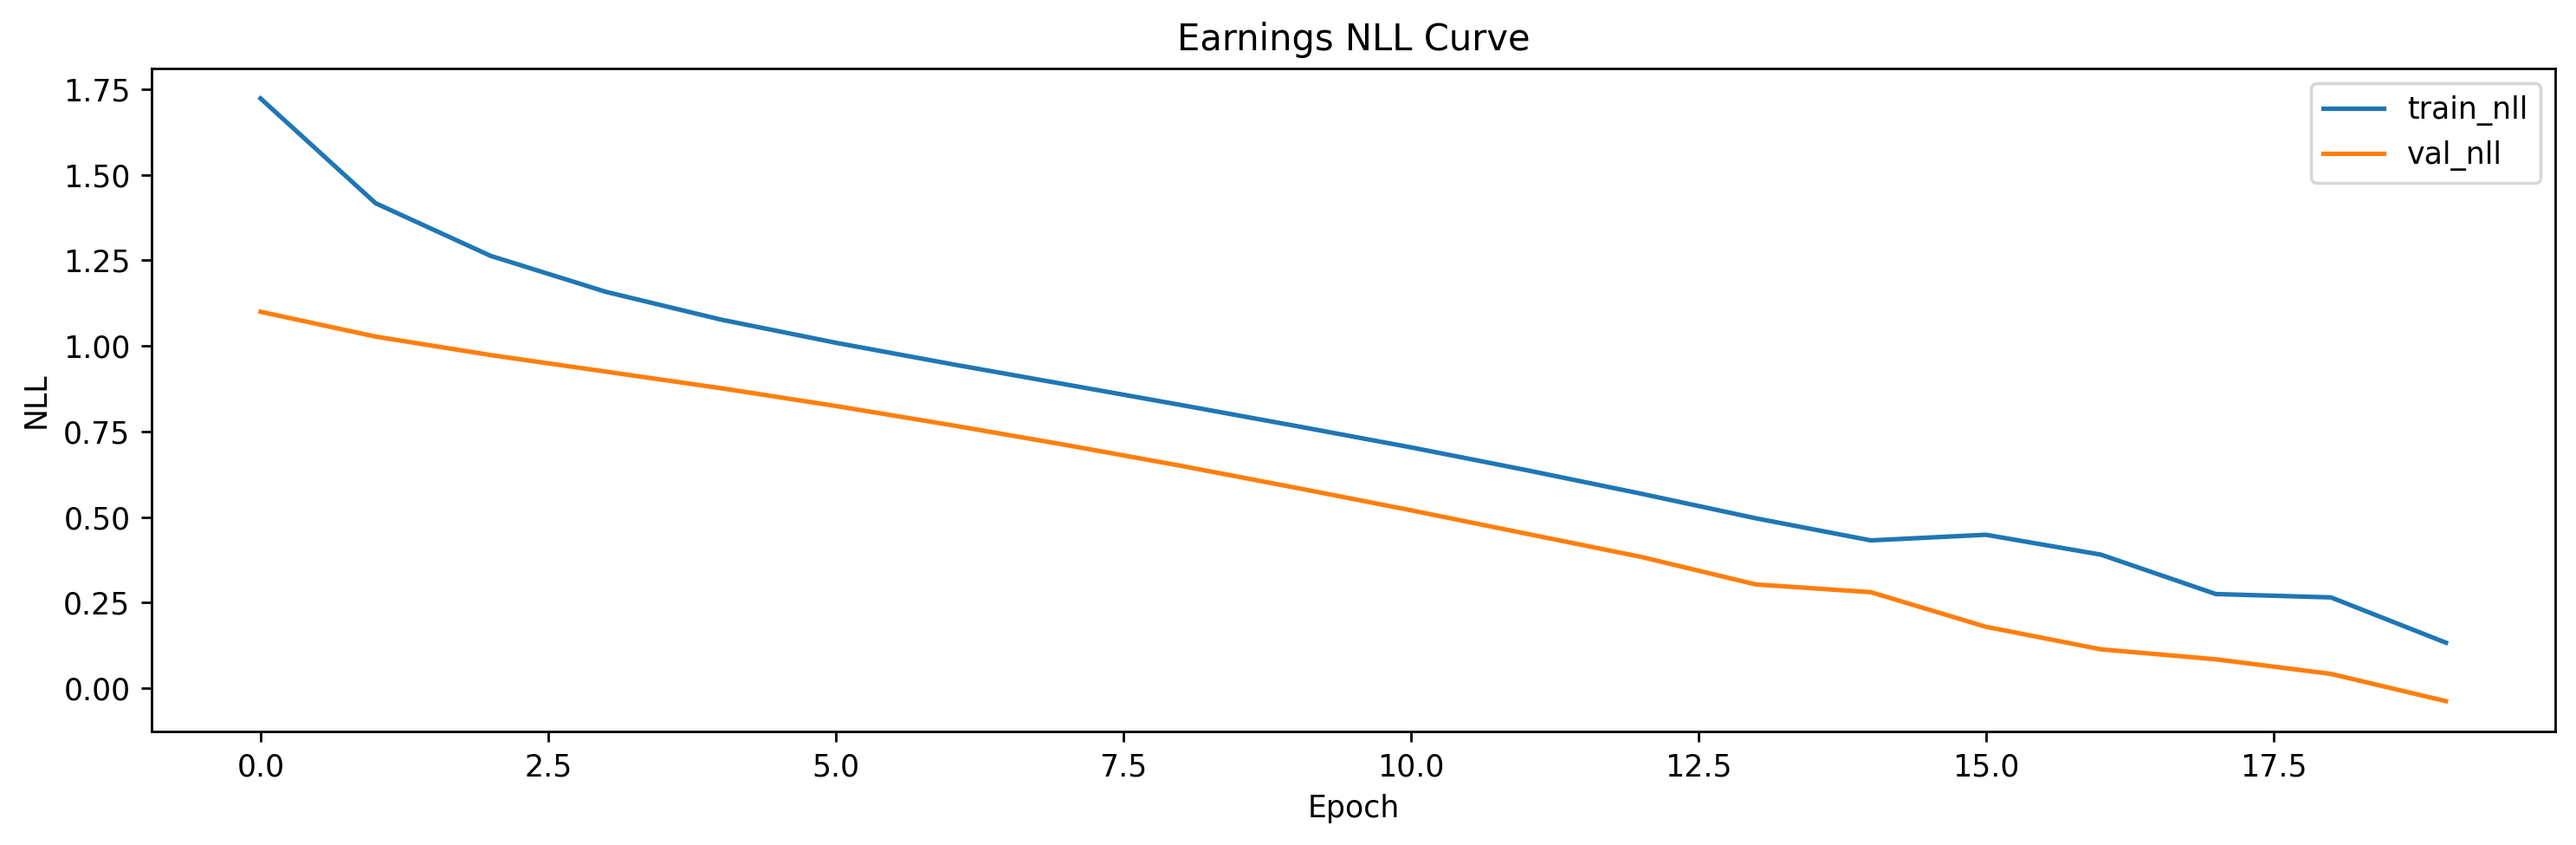

In [18]:
# Visualize training curves for earnings NLL.
nll_key = 'earn_params_loss'
val_nll_key = 'val_earn_params_loss'

if nll_key in hist.history:
    print('NLL curve (train):', '\n', hist.history[nll_key], '\n')

print("=" * 100, '\n')

if val_nll_key in hist.history:
    print('NLL curve (val):', '\n', hist.history[val_nll_key], '\n')

if nll_key in hist.history:
    
    plt.figure(figsize = (12, 4), dpi = 250)
    plt.plot(hist.history[nll_key], label = 'train_nll')

    if val_nll_key in hist.history:
        plt.plot(hist.history[val_nll_key], label = 'val_nll')
    
    plt.title('Earnings NLL Curve')
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.legend()
    plt.tight_layout()
    plt.show()

### 4.3 Per-Ticker Results

#### 4.3.1 Summary

In [19]:
summary_view

,samples,mean_pred_assets,mean_pred_liab,mean_pred_equity,mean_pred_net_income,mean_pred_net_income_std,mean_actual_assets,mean_actual_liab,mean_actual_equity,mean_actual_net_income,mae_assets,mae_liab,mae_equity,mae_net_income
ticker,,,,,,,,,,,,,,
0700.HK,3.00,"1,281,099,431,936.00","252,352,610,304.00","1,028,746,903,552.00","104,113,627,136.00","52,600,618,631.84","1,645,457,333,333.33","741,978,333,333.33","903,479,000,000.00","165,844,000,000.00","364,357,814,016.00","489,625,712,106.67","125,267,881,706.67","61,730,375,594.67"
1810.HK,3.00,"322,663,645,184.00","185,820,643,328.00","136,843,010,048.00","53,494,296,576.00","38,277,829,643.23","333,636,646,333.33","167,839,997,333.33","165,796,649,000.00","14,535,776,333.33","55,995,124,914.67","36,775,268,213.33","28,953,638,952.00","38,958,517,512.00"
9987.HK,3.00,"198,116,245,504.00","188,152,332,288.00","9,963,913,216.00","1,562,877,312.00","5,454,095,395.53","11,659,333,333.33","4,757,333,333.33","6,902,000,000.00","726,666,666.67","186,456,917,632.00","183,395,004,416.00","3,061,913,216.00","3,738,675,669.33"
9988.HK,2.00,"1,325,793,017,856.00","186,862,043,136.00","1,138,931,007,488.00","72,187,158,528.00","30,726,696,280.04","1,758,936,500,000.00","641,176,500,000.00","1,117,760,000,000.00","76,396,000,000.00","433,143,482,144.00","454,314,456,864.00","26,551,229,504.00","4,208,841,472.00"
AAPL,3.00,"234,438,475,776.00","186,045,235,200.00","48,393,261,056.00","81,115,529,216.00","48,046,166,410.34","358,934,666,666.67","294,658,333,333.33","64,276,333,333.33","100,913,666,666.67","124,496,174,506.67","108,613,103,594.67","15,883,070,912.00","19,798,137,450.67"
EL,3.00,"200,329,314,304.00","193,915,568,128.00","6,413,729,792.00","3,340,879,872.00","8,495,939,411.00","21,661,333,333.33","16,462,666,666.67","5,198,666,666.67","87,666,666.67","178,667,964,586.67","177,452,901,461.33","3,816,881,621.33","3,672,412,778.67"
GOOG,2.00,"452,751,589,376.00","185,758,236,672.00","266,993,336,320.00","59,110,494,208.00","20,216,311,432.09","383,828,000,000.00","114,066,500,000.00","269,761,500,000.00","66,883,500,000.00","68,923,572,992.00","71,691,736,672.00","11,266,600,800.00","7,773,005,792.00"
IBM,3.00,"460,114,788,352.00","273,936,105,472.00","186,178,666,496.00","37,903,822,848.00","23,792,724,457.14","133,219,666,666.67","109,210,666,666.67","24,009,000,000.00","5,055,000,000.00","326,895,110,762.67","164,725,433,344.00","162,169,666,496.00","32,848,822,848.00"
KO,3.00,"282,625,933,312.00","225,589,723,136.00","57,036,189,696.00","22,670,997,504.00","20,601,647,743.11","97,005,000,000.00","70,445,666,666.67","26,559,333,333.33","10,295,666,666.67","185,620,911,466.67","155,144,056,469.33","30,476,852,266.67","12,375,330,837.33"


#### 4.3.2 Prediction Plots

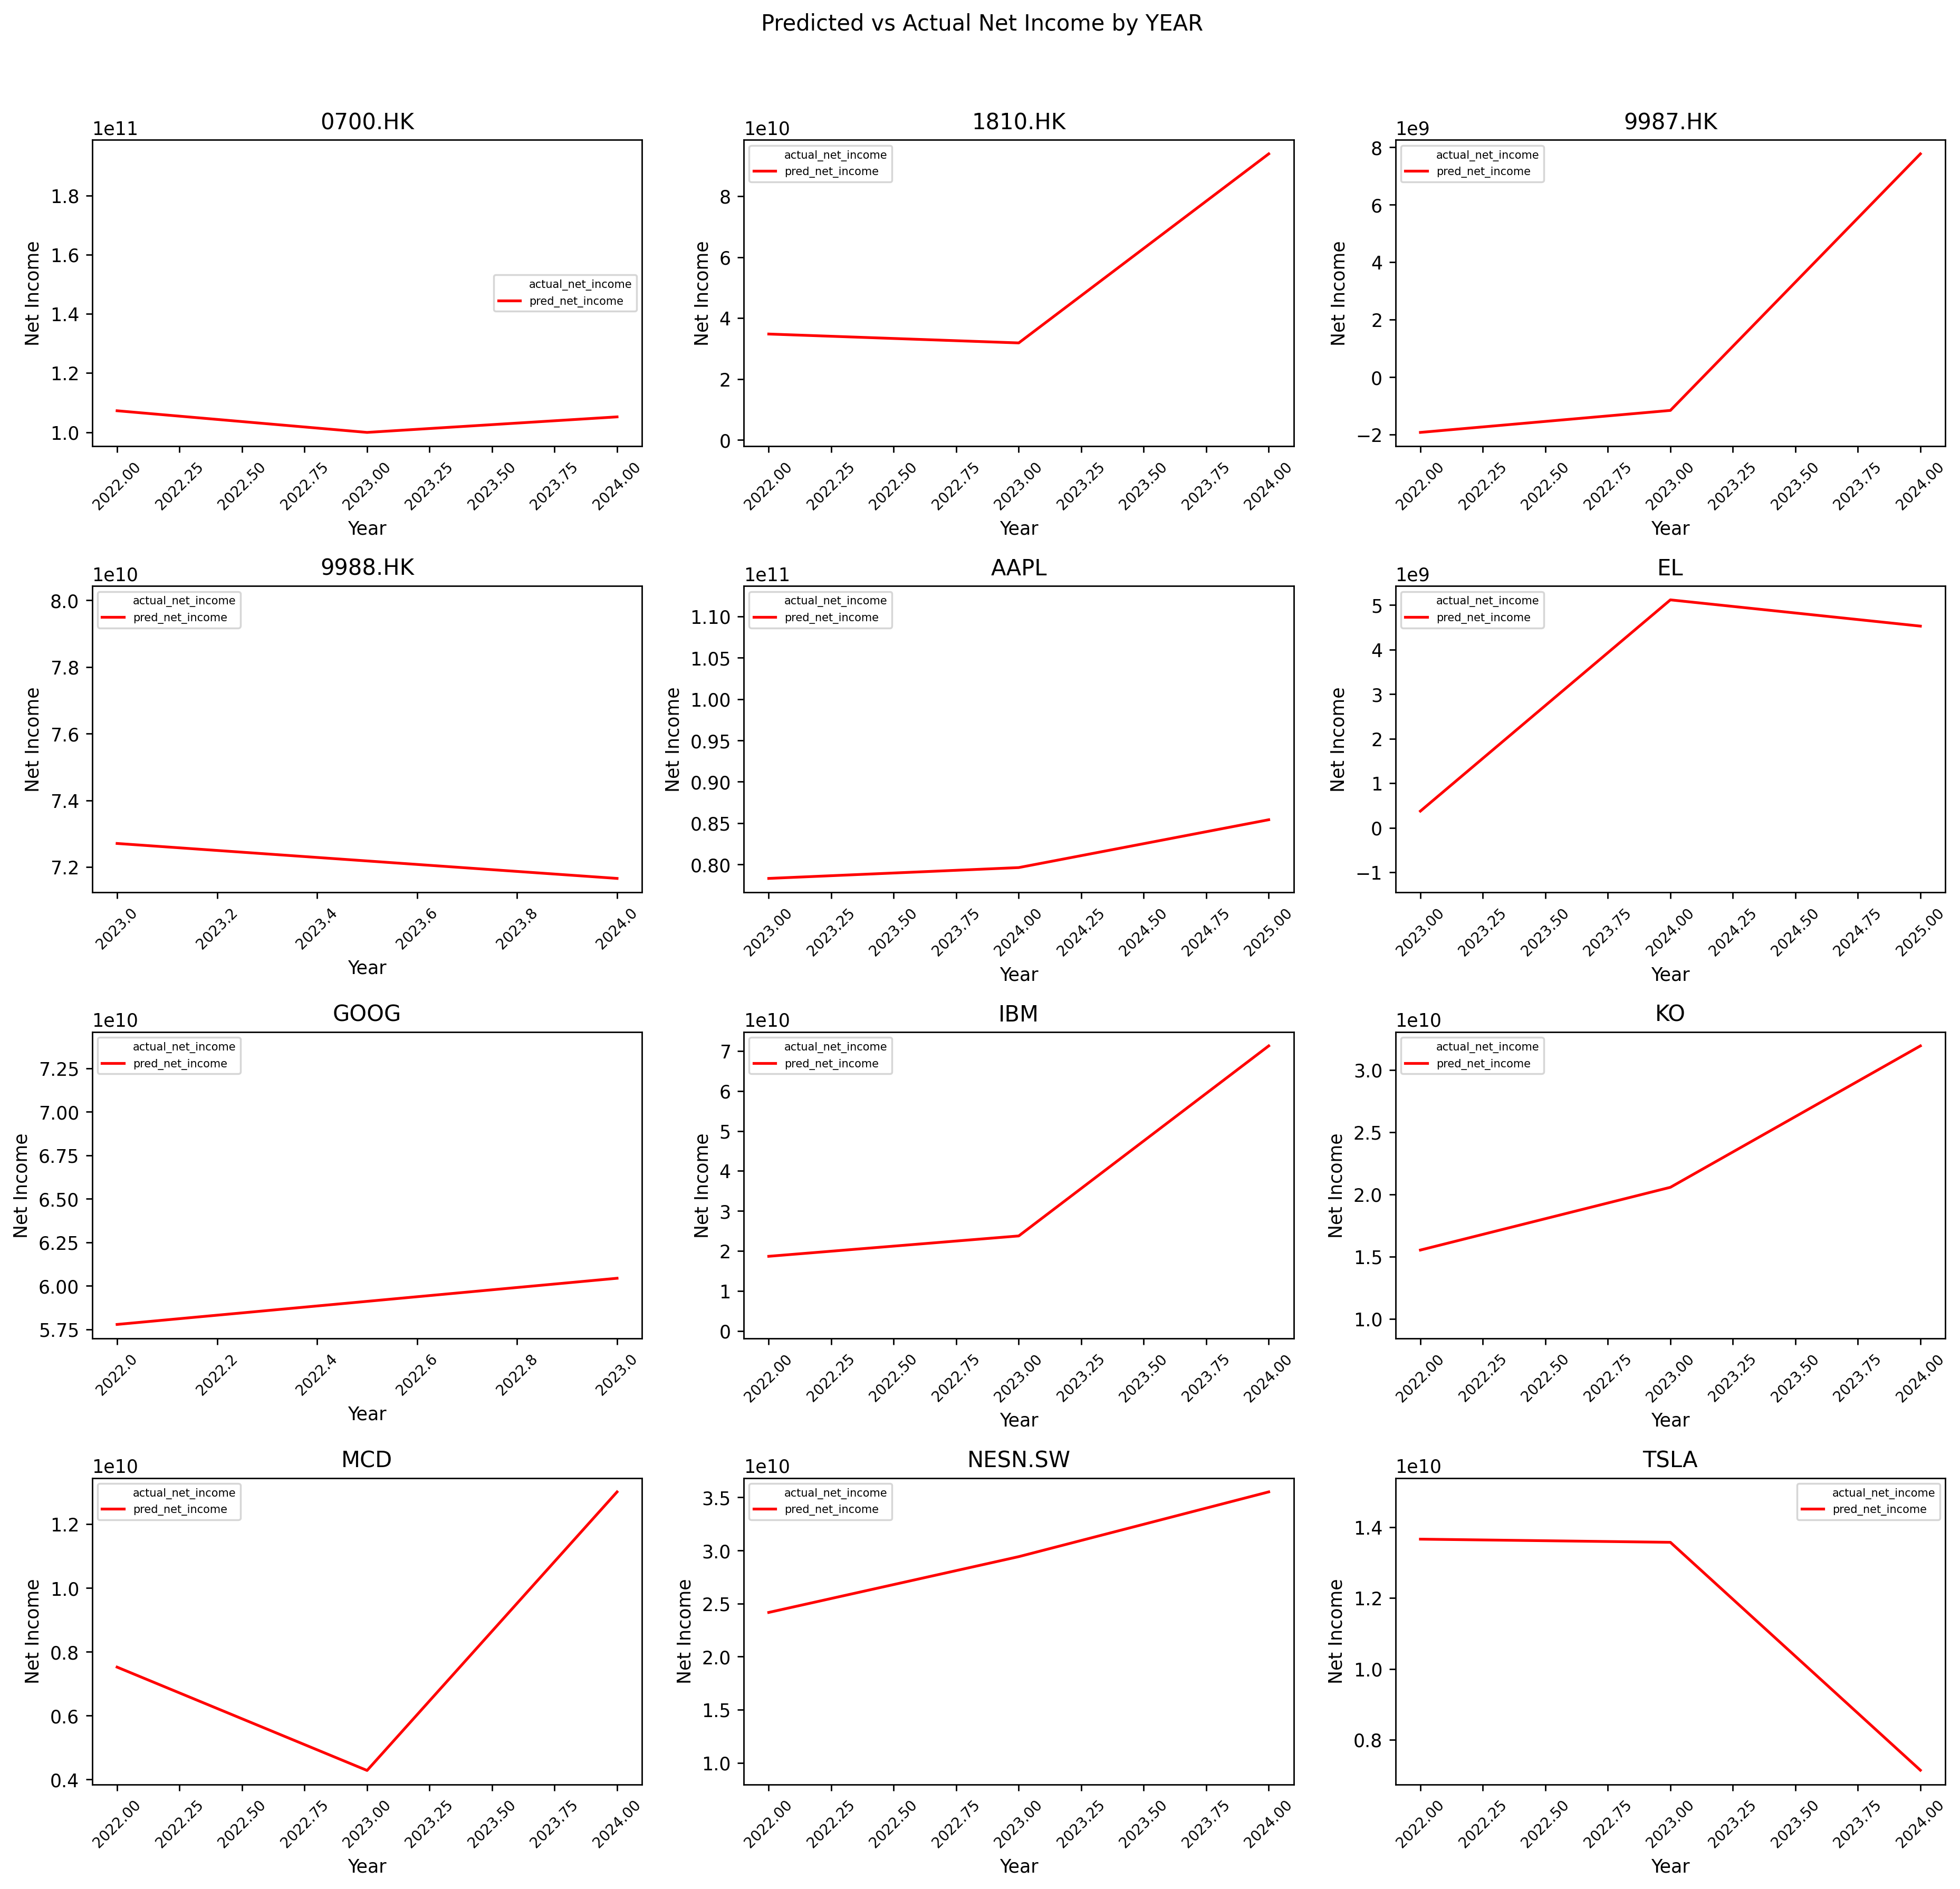

In [20]:
# Visualize predicted vs actual net income over time per ticker.
plot_df = pred_full.copy()

if TARGET_FREQ == 'yearly':
    plot_df['period'] = plot_df['stmt_year']
    x_label = 'Year'
    title_suffix = 'Year'

else:
    plot_df['period'] = plot_df['stmt_date'].dt.to_period('Q')
    x_label = 'Quarter'
    title_suffix = 'Quarter'

period_df = plot_df.groupby(['ticker', 'period']).agg(
    pred_net_income = ('pred_net_income', 'mean'),
    actual_net_income = ('actual_net_income', 'mean'),
    pred_assets = ('Total Assets', 'mean'),
    actual_assets = ('actual_Total Assets', 'mean'),
)

period_df = period_df.reset_index()
tickers = sorted(period_df['ticker'].unique())
ncols = 3
nrows = int(np.ceil(len(tickers) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize = (5 * ncols, 3.5 * nrows), sharex = False, dpi = 250)
axes = np.array(axes).reshape(-1)

for ax, ticker in zip(axes, tickers):

    data = period_df[period_df['ticker'] == ticker].sort_values('period')
    x_vals = data['period'].astype(str) if TARGET_FREQ != 'yearly' else data['period']
    ax.plot(x_vals, data['actual_net_income'], label = 'actual_net_income', color = 'white')
    ax.plot(x_vals, data['pred_net_income'], label = 'pred_net_income', color = 'red')
    ax.set_title(ticker)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Net Income')
    ax.tick_params(axis = 'x', labelsize = 8, rotation = 45)

    if TARGET_FREQ != 'yearly':
        ax.tick_params(axis = 'x', rotation = 45)

    ax.legend(fontsize = 6)

for ax in axes[len(tickers):]:
    ax.axis('off')

fig.suptitle(f'Predicted vs Actual Net Income by {title_suffix.upper()}', y = 1.02)
fig.tight_layout()

plt.show()

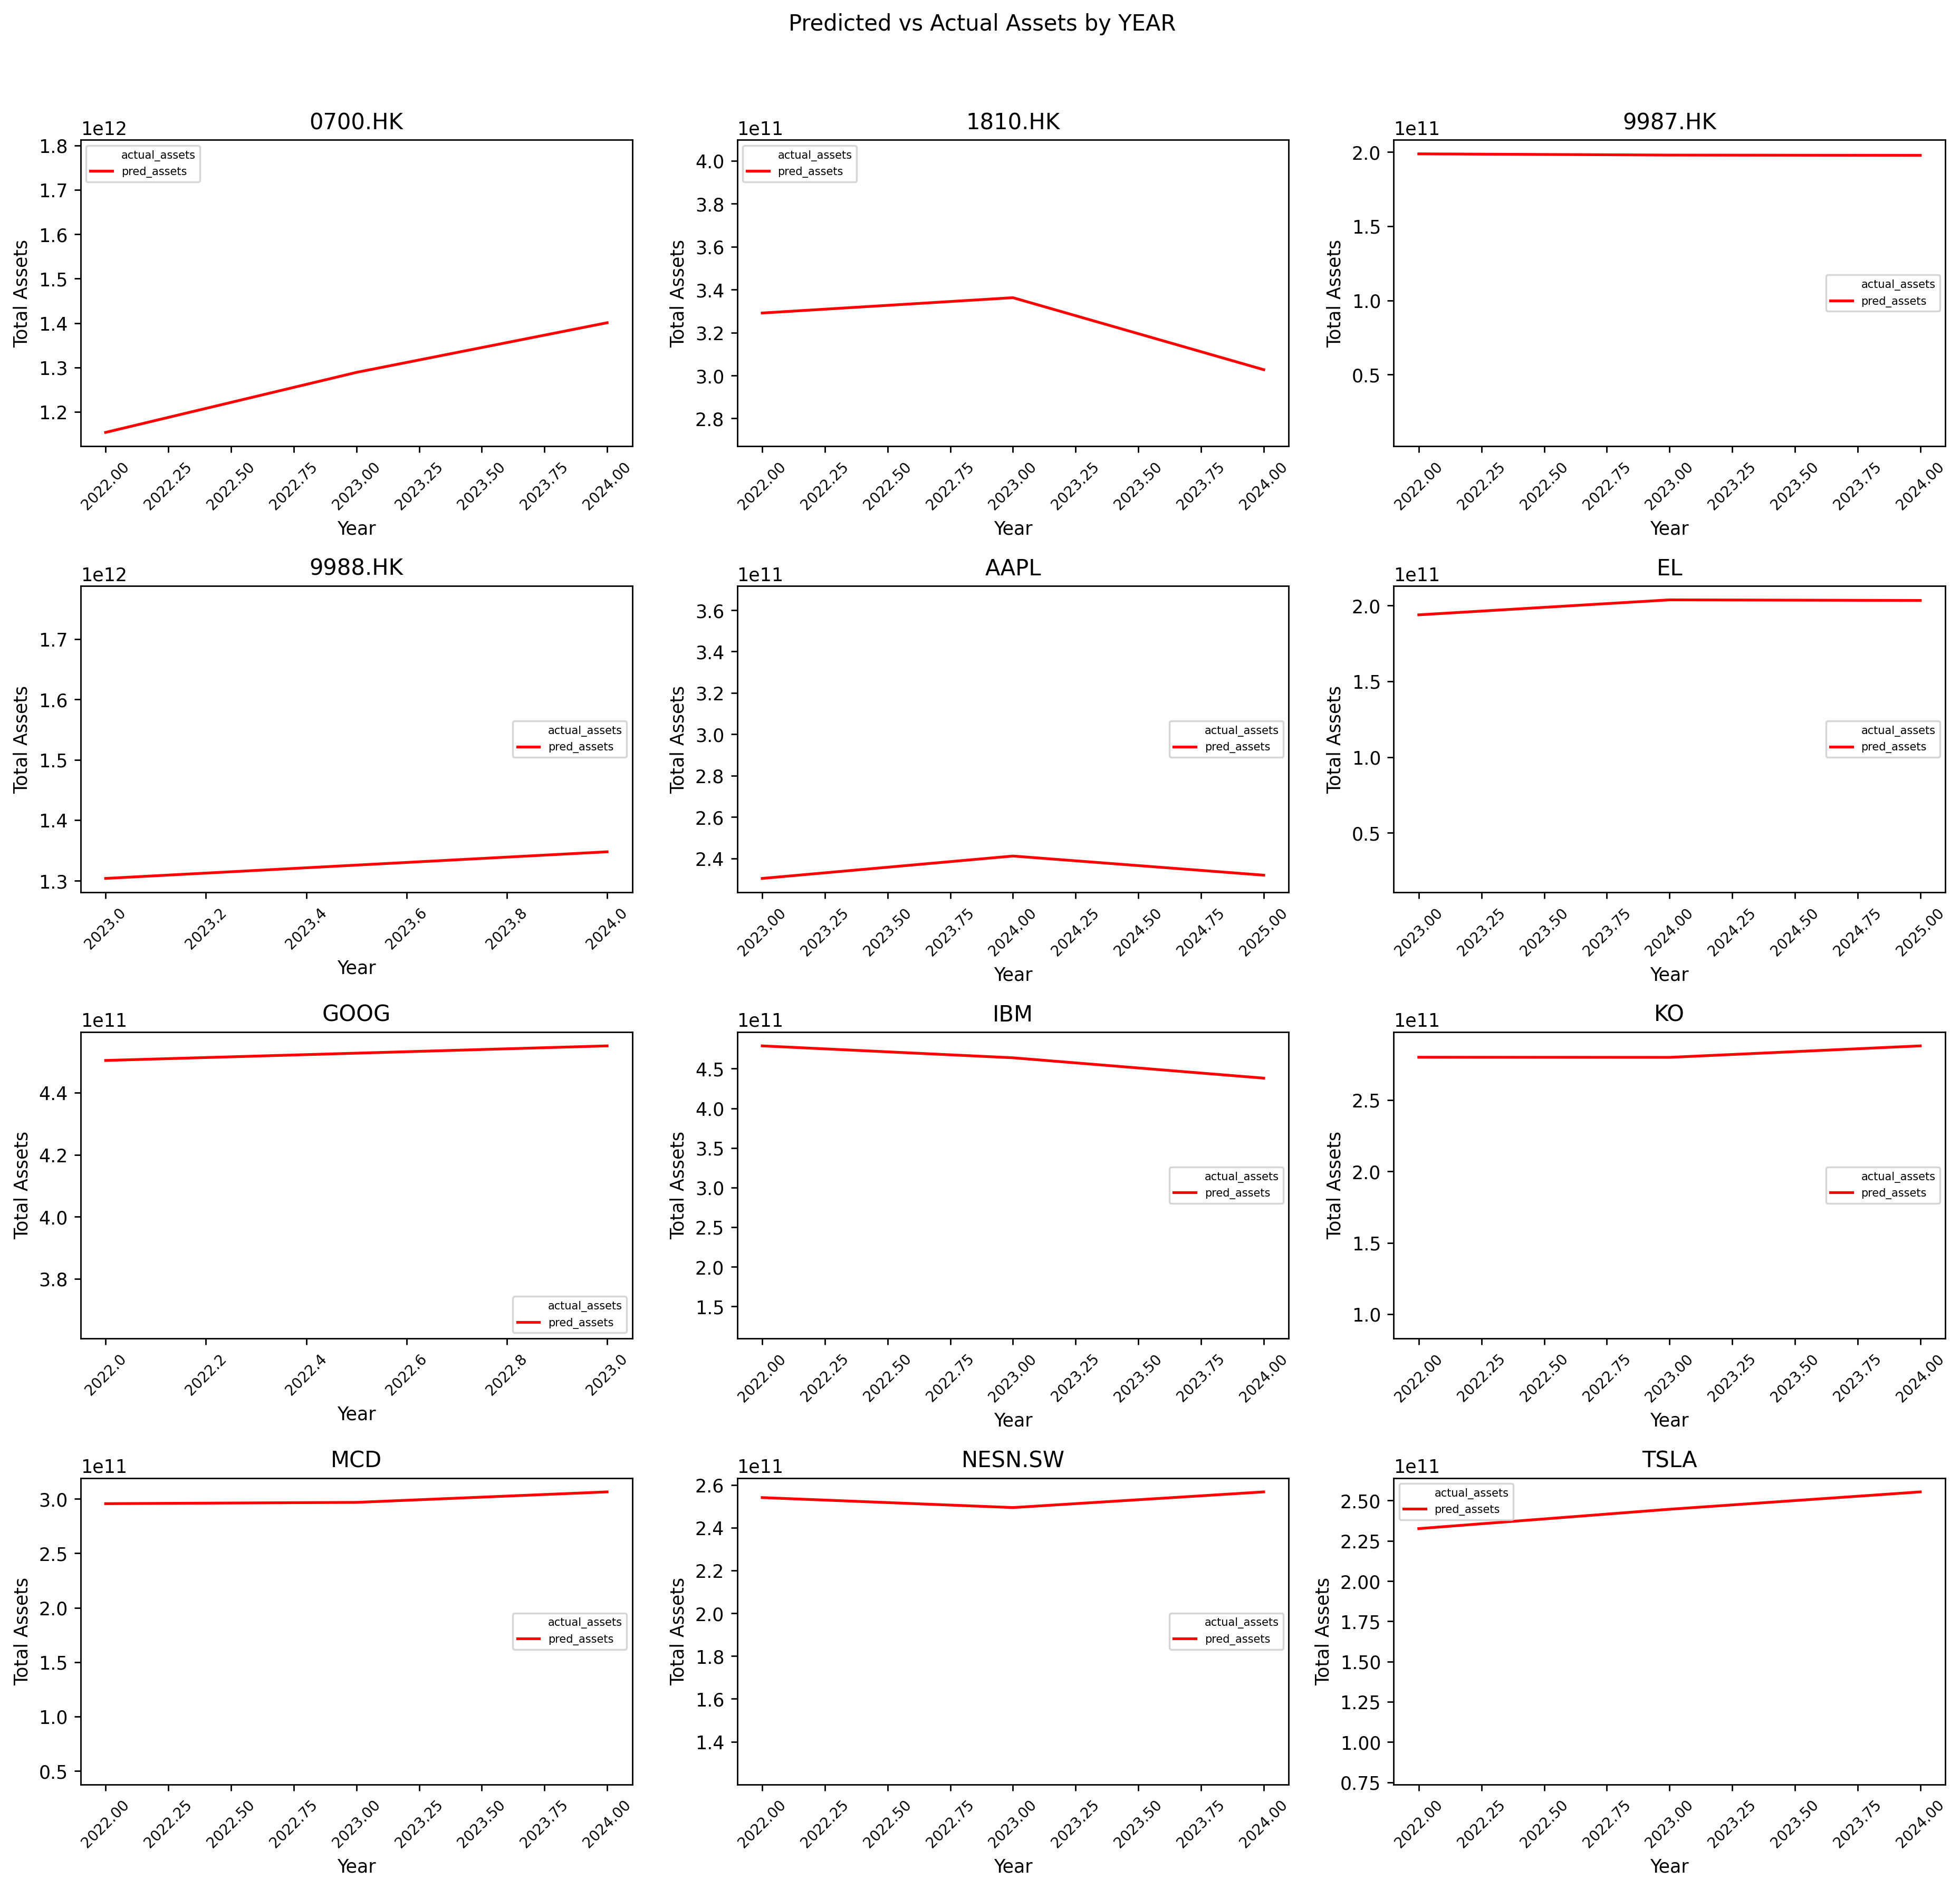

In [21]:
# Visualize predicted vs actual total assets over time per ticker.
fig, axes = plt.subplots(nrows, ncols, figsize = (5 * ncols, 3.5 * nrows), sharex = False, dpi = 250)
axes = np.array(axes).reshape(-1)

for ax, ticker in zip(axes, tickers):

    data = period_df[period_df['ticker'] == ticker].sort_values('period')
    x_vals = data['period'].astype(str) if TARGET_FREQ != 'yearly' else data['period']
    ax.plot(x_vals, data['actual_assets'], label = 'actual_assets', color = 'white')
    ax.plot(x_vals, data['pred_assets'], label = 'pred_assets', color = 'red')
    ax.set_title(ticker)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Total Assets')
    ax.tick_params(axis = 'x', labelsize = 8, rotation = 45)

    if TARGET_FREQ != 'yearly':
        ax.tick_params(axis = 'x', rotation = 45)

    ax.legend(fontsize = 6)

for ax in axes[len(tickers):]:
    ax.axis('off')

fig.suptitle(f'Predicted vs Actual Assets by {title_suffix.upper()}', y = 1.02)
fig.tight_layout()

plt.show()

#### 4.3.3 Full Predictions

In [22]:
pred_full_view

,,,,,stmt_date,Total Assets,Total Liabilities,Total Equity,stmt_freq,pred_net_income,pred_net_income_std,pred_resid,actual_Total Assets,actual_Total Liabilities,...,actual_net_income,err_assets,err_liab,err_equity,err_net_income,abs_err_assets,abs_err_liab,abs_err_equity,abs_err_net_income,stmt_year
ticker,fiscal_q1,fiscal_q2,fiscal_q3,fiscal_q4,,,,,,,,,,,,,,,,,,,,,
MCD,0,0,0,1,2022-12-31,"295,644,659,712.00","240,434,610,176.00","55,210,049,536.00",yearly,"7,520,581,632.00","12,734,864,604.36",0.00,"50,435,600,000.00","56,439,000,000.00",...,"6,177,000,000.00","245,209,059,712.00","183,995,610,176.00","61,213,449,536.00","1,343,581,632.00","245,209,059,712.00","183,995,610,176.00","61,213,449,536.00","1,343,581,632.00","2,022.00"
KO,0,0,0,1,2022-12-31,"279,991,451,648.00","229,634,424,832.00","50,357,026,816.00",yearly,"15,520,450,560.00","18,867,868,290.25",0.00,"92,763,000,000.00","66,937,000,000.00",...,"9,542,000,000.00","187,228,451,648.00","162,697,424,832.00","24,531,026,816.00","5,978,450,560.00","187,228,451,648.00","162,697,424,832.00","24,531,026,816.00","5,978,450,560.00","2,022.00"
NESN.SW,0,0,0,1,2022-12-31,"254,051,762,176.00","185,758,236,672.00","68,293,525,504.00",yearly,"24,158,488,576.00","23,629,994,084.46",0.00,"135,182,000,000.00","92,390,000,000.00",...,"9,270,000,000.00","118,869,762,176.00","93,368,236,672.00","25,501,525,504.00","14,888,488,576.00","118,869,762,176.00","93,368,236,672.00","25,501,525,504.00","14,888,488,576.00","2,022.00"
GOOG,0,0,0,1,2022-12-31,"450,400,681,984.00","185,758,236,672.00","264,642,428,928.00",yearly,"57,783,484,416.00","20,420,917,876.51",0.00,"365,264,000,000.00","109,120,000,000.00",...,"59,972,000,000.00","85,136,681,984.00","76,638,236,672.00","8,498,428,928.00","-2,188,515,584.00","85,136,681,984.00","76,638,236,672.00","8,498,428,928.00","2,188,515,584.00","2,022.00"
0700.HK,0,0,0,1,2022-12-31,"1,153,739,653,120.00","228,402,069,504.00","925,337,583,616.00",yearly,"107,242,258,432.00","60,812,803,650.78",0.00,"1,578,131,000,000.00","795,271,000,000.00",...,"188,243,000,000.00","-424,391,346,880.00","-566,868,930,496.00","142,477,583,616.00","-81,000,741,568.00","424,391,346,880.00","566,868,930,496.00","142,477,583,616.00","81,000,741,568.00","2,022.00"
9987.HK,0,0,0,1,2022-12-31,"198,719,160,320.00","188,211,265,536.00","10,507,894,784.00",yearly,"-1,925,124,096.00","5,225,677,380.13",0.00,"11,826,000,000.00","4,666,000,000.00",...,"442,000,000.00","186,893,160,320.00","183,545,265,536.00","3,347,894,784.00","-2,367,124,096.00","186,893,160,320.00","183,545,265,536.00","3,347,894,784.00","2,367,124,096.00","2,022.00"
TSLA,0,0,0,1,2022-12-31,"232,587,345,920.00","185,758,236,672.00","46,829,109,248.00",yearly,"13,663,969,280.00","4,916,081,024.35",0.00,"82,338,000,000.00","36,440,000,000.00",...,"12,583,000,000.00","150,249,345,920.00","149,318,236,672.00","931,109,248.00","1,080,969,280.00","150,249,345,920.00","149,318,236,672.00","931,109,248.00","1,080,969,280.00","2,022.00"
1810.HK,0,0,0,1,2022-12-31,"329,075,916,800.00","185,857,458,176.00","143,218,458,624.00",yearly,"34,757,132,288.00","36,754,175,597.26",0.00,"273,507,211,000.00","129,584,151,000.00",...,"2,474,030,000.00","55,568,705,800.00","56,273,307,176.00","-704,601,376.00","32,283,102,288.00","55,568,705,800.00","56,273,307,176.00","704,601,376.00","32,283,102,288.00","2,022.00"
IBM,0,0,0,1,2022-12-31,"478,690,476,032.00","277,218,295,808.00","201,472,180,224.00",yearly,"18,672,881,664.00","19,170,767,386.24",0.00,"127,243,000,000.00","105,222,000,000.00",...,"1,640,000,000.00","351,447,476,032.00","171,996,295,808.00","179,451,180,224.00","17,032,881,664.00","351,447,476,032.00","171,996,295,808.00","179,451,180,224.00","17,032,881,664.00","2,022.00"


## 5. Out of Sample Test
---
Evaluate the trained model on a held-out tail of the time series.

### 5.1 OOS Test

In [23]:
# Out-of-sample evaluation on the held-out tail.

if X_test_feat.shape[0] == 0:
    print('OOS: no samples available for evaluation.')

else:
    bs_test_scaled, earn_test_params_scaled = pareja_model([X_test_feat, X_test_prev], training = False)
    bs_test_pred = bs_scaler.inverse_transform(bs_test_scaled.numpy())
    earn_loc_scaled = earn_test_params_scaled[:, :1]
    earn_scale_scaled = tf.nn.softplus(earn_test_params_scaled[:, 1:]) + 1e-3
    earn_test_pred = earn_scaler.inverse_transform(earn_loc_scaled.numpy())
    earn_test_pred_std = earn_scale_scaled.numpy() * earn_scaler.scale_[0]

    aligned_test = aligned.iloc[test_mask].copy()
    pred_le = pd.DataFrame(bs_test_pred, columns = TARGET_LE, index = aligned_test.index)
    pred_assets = pred_le['Total Liabilities'] + pred_le['Total Equity']

    actual_liab = aligned_test['Total Liabilities']
    actual_equity = aligned_test['Total Equity']
    actual_assets = aligned_test['Total Assets']
    actual_earn = aligned_test[NET_INCOME_COL]

    metrics = pd.DataFrame(
        {
            'mae_liab': [(pred_le['Total Liabilities'] - actual_liab).abs().mean()],
            'mae_equity': [(pred_le['Total Equity'] - actual_equity).abs().mean()],
            'mae_assets': [(pred_assets - actual_assets).abs().mean()],
            'mae_net_income': [np.abs(earn_test_pred.flatten() - actual_earn.values).mean()],
            'identity_resid_mean': [(pred_assets - (pred_le['Total Liabilities'] + pred_le['Total Equity'])).abs().mean()],
        }
    )

    per_ticker_metrics = aligned_test.copy()
    per_ticker_metrics['pred_liab'] = pred_le['Total Liabilities']
    per_ticker_metrics['pred_equity'] = pred_le['Total Equity']
    per_ticker_metrics['pred_assets'] = pred_assets
    per_ticker_metrics['pred_net_income'] = earn_test_pred.flatten()
    per_ticker_metrics['err_liab'] = per_ticker_metrics['pred_liab'] - actual_liab
    per_ticker_metrics['err_equity'] = per_ticker_metrics['pred_equity'] - actual_equity
    per_ticker_metrics['err_assets'] = per_ticker_metrics['pred_assets'] - actual_assets
    per_ticker_metrics['err_net_income'] = per_ticker_metrics['pred_net_income'] - actual_earn.values

    per_ticker_metrics = per_ticker_metrics.groupby('ticker').agg(
        samples = ('err_net_income', 'size'),
        mae_liab = ('err_liab', lambda s: s.abs().mean()),
        mae_equity = ('err_equity', lambda s: s.abs().mean()),
        mae_assets = ('err_assets', lambda s: s.abs().mean()),
        mae_net_income = ('err_net_income', lambda s: s.abs().mean()),
    ).sort_index()

### 5.2 OOS Metrics

In [24]:
metrics

,mae_liab,mae_equity,mae_assets,mae_net_income,identity_resid_mean
0,"170,614,942,984.00","48,838,408,527.20","196,847,669,130.40","31,423,003,822.40",0.00


In [25]:
per_ticker_metrics

,samples,mae_liab,mae_equity,mae_assets,mae_net_income
ticker,,,,,
0700.HK,1,"489,093,334,208.00","108,800,065,024.00","380,293,285,568.00","88,899,516,480.00"
1810.HK,1,"28,191,933,328.00","72,260,247,576.00","100,452,172,712.00","70,228,591,952.00"
9987.HK,1,"183,372,775,040.00","3,243,541,312.00","186,616,316,352.00","6,862,329,408.00"
AAPL,1,"99,518,224,640.00","27,844,447,040.00","127,362,671,680.00","26,599,552,640.00"
EL,1,"179,547,693,888.00","3,923,363,776.00","183,471,057,664.00","5,661,252,928.00"
IBM,1,"165,981,200,000.00","134,831,357,376.00","300,812,573,760.00","65,252,405,312.00"
KO,1,"150,177,631,680.00","37,235,988,224.00","187,413,628,096.00","21,298,473,024.00"
MCD,1,"183,276,560,704.00","68,001,914,688.00","251,278,491,776.00","4,788,251,200.00"
NESN.SW,1,"89,432,571,712.00","28,014,796,992.00","117,447,360,512.00","24,633,399,040.00"


### 5.3 OOS Plots

In [26]:
# Diagnostics for per-ticker split sizes.

diag_rows = []

for ticker in aligned['ticker'].unique():
    pos = np.where(aligned['ticker'].values == ticker)[0]
    pos = pos[np.argsort(aligned.index.values[pos])]
    diag_rows.append(
        {
            'ticker': ticker,
            'total_rows': len(pos),
            'train_rows': int(train_mask[pos].sum()),
            'val_rows': int(val_mask[pos].sum()),
            'test_rows': int(test_mask[pos].sum()),
        }
    )

diag_df = pd.DataFrame(diag_rows).sort_values('ticker')


diag_df

,ticker,total_rows,train_rows,val_rows,test_rows
4,0700.HK,3,1,1,1
7,1810.HK,3,1,1,1
5,9987.HK,3,1,1,1
9,9988.HK,2,2,0,0
11,AAPL,3,1,1,1
10,EL,3,1,1,1
3,GOOG,2,2,0,0
8,IBM,3,1,1,1
1,KO,3,1,1,1
0,MCD,3,1,1,1


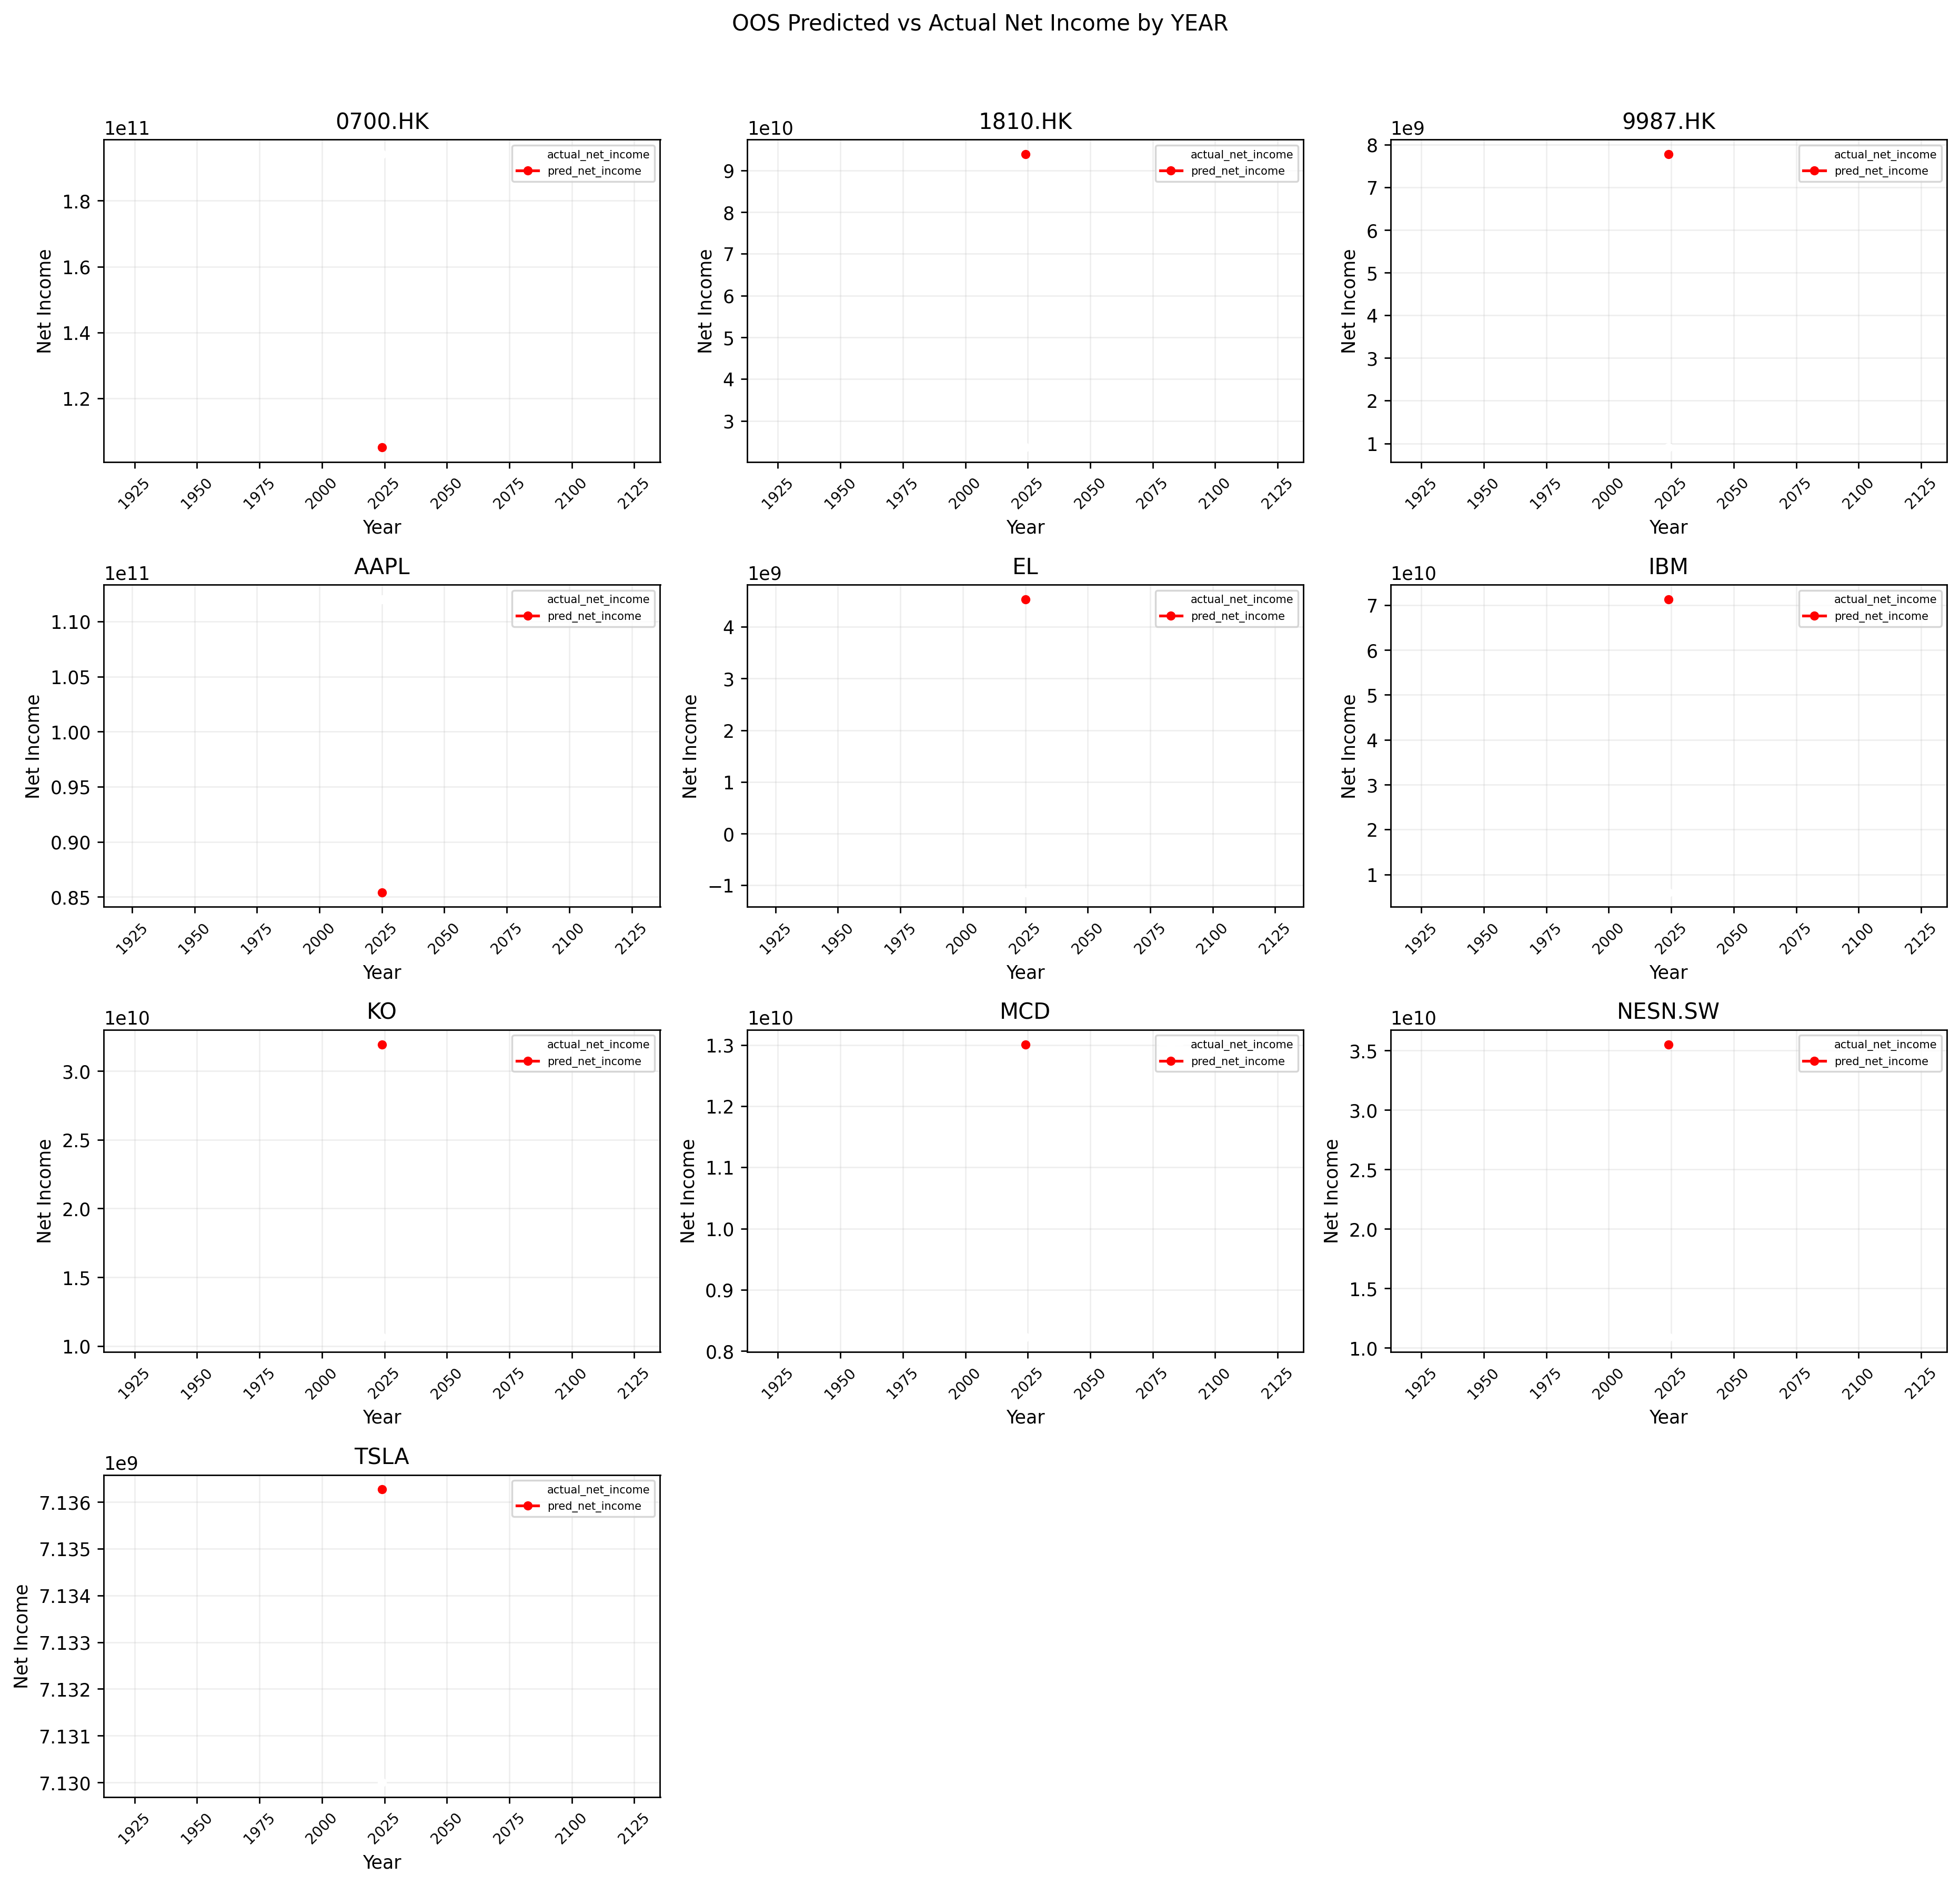

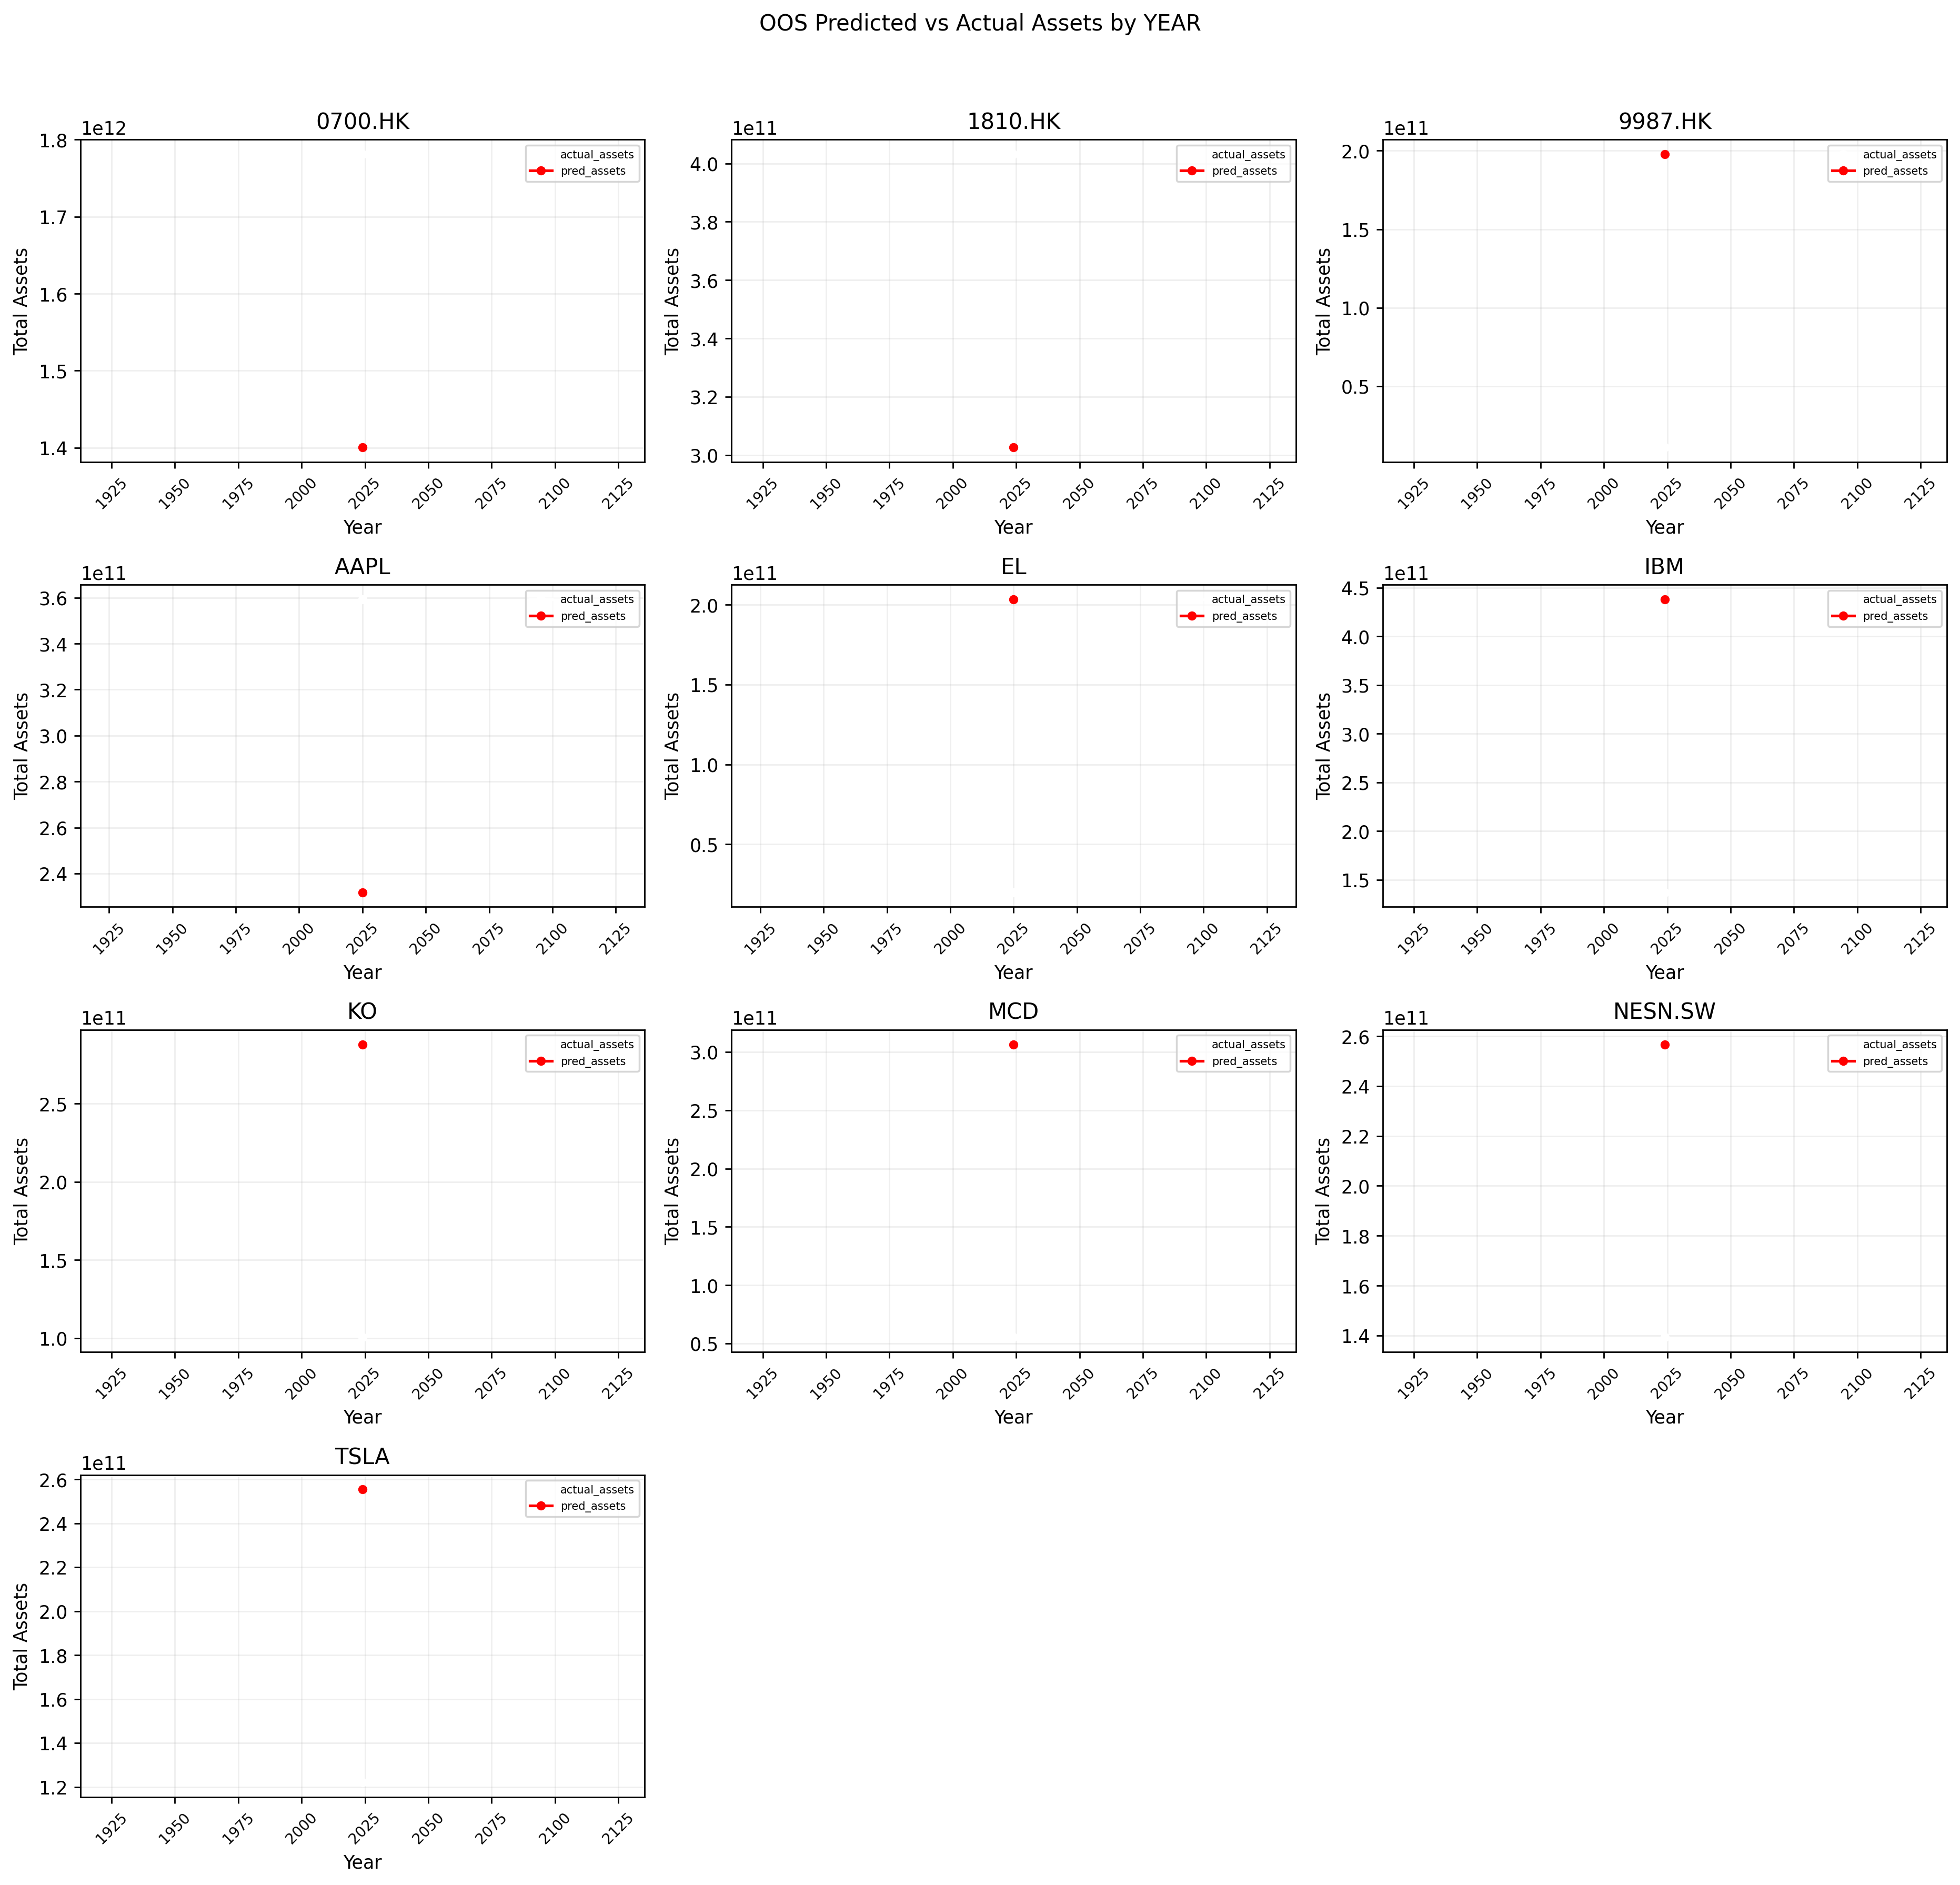

In [27]:
# OOS plots for net income and total assets.

if X_test_feat.shape[0] == 0:
    print('OOS: no samples available for plotting.')

else:
    oos_df = aligned_test.copy()
    oos_df['pred_net_income'] = earn_test_pred.flatten()
    oos_df['pred_total_assets'] = pred_assets.values
    oos_df['actual_net_income'] = actual_earn.values
    oos_df['actual_total_assets'] = actual_assets.values

    if TARGET_FREQ == 'yearly':

        oos_df['period'] = oos_df.index.year
        x_label = 'Year'
        title_suffix = 'Year'

    else:
        oos_df['period'] = oos_df.index.to_period('Q')
        x_label = 'Quarter'
        title_suffix = 'Quarter'

    period_oos = oos_df.groupby(['ticker', 'period']).agg(
        pred_net_income = ('pred_net_income', 'mean'),
        actual_net_income = ('actual_net_income', 'mean'),
        pred_assets = ('pred_total_assets', 'mean'),
        actual_assets = ('actual_total_assets', 'mean'),
    ).reset_index()

    tickers = sorted(period_oos['ticker'].unique())

    if not tickers:
        print('OOS: no tickers available for plotting.')

    else:
        ncols = 3
        nrows = int(np.ceil(len(tickers) / ncols))

        fig, axes = plt.subplots(nrows, ncols, figsize = (5 * ncols, 3.5 * nrows), sharex = False, dpi = 250)
        axes = np.array(axes).reshape(-1)

        for ax, ticker in zip(axes, tickers):

            data = period_oos[period_oos['ticker'] == ticker].sort_values('period')
            x_vals = data['period'].astype(str) if TARGET_FREQ != 'yearly' else data['period']
            ax.plot(x_vals, data['actual_net_income'], label = 'actual_net_income', color = 'white', marker = 'o', markersize = 4, linewidth = 1.5)
            ax.plot(x_vals, data['pred_net_income'], label = 'pred_net_income', color = 'red', marker = 'o', markersize = 4, linewidth = 1.5)
            ax.set_title(ticker)
            ax.set_xlabel(x_label)
            ax.set_ylabel('Net Income')
            ax.tick_params(axis = 'x', labelsize = 8, rotation = 45)
            ax.legend(fontsize = 6)
            ax.grid(True, alpha = 0.2)

        for ax in axes[len(tickers):]:
            ax.axis('off')

        fig.suptitle(f'OOS Predicted vs Actual Net Income by {title_suffix.upper()}', y = 1.02)
        fig.tight_layout()

        plt.show()

        fig, axes = plt.subplots(nrows, ncols, figsize = (5 * ncols, 3.5 * nrows), sharex = False, dpi = 250)
        axes = np.array(axes).reshape(-1)

        for ax, ticker in zip(axes, tickers):

            data = period_oos[period_oos['ticker'] == ticker].sort_values('period')
            x_vals = data['period'].astype(str) if TARGET_FREQ != 'yearly' else data['period']
            ax.plot(x_vals, data['actual_assets'], label = 'actual_assets', color = 'white', marker = 'o', markersize = 4, linewidth = 1.5)
            ax.plot(x_vals, data['pred_assets'], label = 'pred_assets', color = 'red', marker = 'o', markersize = 4, linewidth = 1.5)
            ax.set_title(ticker)
            ax.set_xlabel(x_label)
            ax.set_ylabel('Total Assets')
            ax.tick_params(axis = 'x', labelsize = 8, rotation = 45)
            ax.legend(fontsize = 6)
            ax.grid(True, alpha = 0.2)

        for ax in axes[len(tickers):]:
            ax.axis('off')

        fig.suptitle(f'OOS Predicted vs Actual Assets by {title_suffix.upper()}', y = 1.02)
        fig.tight_layout()
        
        plt.show()